## Data Collection

In [ ]:
import tensorflow as tf
import requests
import re
import pandas as pd
import os
import tqdm
import json
%pip install youtube_transcript_api
from youtube_transcript_api import YouTubeTranscriptApi
from openai import OpenAI
import csv
import os.path
import re
import sys
from io import StringIO
import pandas as pd
import argparse
import ast

api_key = "Enter api key"


# Define the feature description to decode the features
feature_description = {
    "id": tf.io.FixedLenFeature([], tf.string),
    "labels": tf.io.VarLenFeature(tf.int64),
}

# Function to parse a single example
def _parse_function(example_proto):
    return tf.io.parse_single_example(example_proto, feature_description)

# Function to extract YouTube ID from the 4-character ID
def get_youtube_id(four_char_id):
    base_url = "https://data.yt8m.org/2/j/i"
    sub_path = f"/{four_char_id[:2]}/{four_char_id}.js"
    url = base_url + sub_path

    try:
        response = requests.get(url, verify=False)
        response.raise_for_status()  # Raise an HTTPError for bad responses

        # Extract the YouTube ID using a regular expression
        match = re.search(r'i\(".*?","(.*?)"\);', response.text)
        if match:
            return match.group(1)
        else:
            return None
    except requests.exceptions.RequestException:
        return None

# Function to get transcript for a YouTube video
def get_transcript(video_id):
    try:
        transcript = YouTubeTranscriptApi.get_transcript(video_id)
        return " ".join([entry['text'] for entry in transcript])
    except Exception:
        return None

# Directory containing the TFRecord files
tfrecord_dir = "/content/files"  # Update with your directory path
output_dir = "./output_json_files"  # Directory to save JSON files
os.makedirs(output_dir, exist_ok=True)

# Process each TFRecord file
for tfrecord_file in os.listdir(tfrecord_dir):
    if tfrecord_file.endswith(".tfrecord"):
        tfrecord_path = os.path.join(tfrecord_dir, tfrecord_file)
        output_path = os.path.join(output_dir, f"{os.path.splitext(tfrecord_file)[0]}.json")
        print(output_path)

        # Create a dataset from the TFRecord file
        dataset = tf.data.TFRecordDataset(tfrecord_path)
        dataset = dataset.map(_parse_function)

        # Extract the 4-digit codes from the 'id' field and keep the labels and id together as a tuple
        codes = [(example['id'].numpy().decode('utf-8'), example['labels'].values.numpy()) for example in dataset]

        # Print the extracted codes
        print("Extracted Codes:", codes)


        # Example usage
        youtube_ids = []
        for four_char_id, labels in tqdm.tqdm(codes):
            print(f"Getting YouTube ID for {four_char_id}")
            youtube_id = get_youtube_id(four_char_id)
            if youtube_id != "Error":
                youtube_ids.append([youtube_id, labels])

        with open('Vocabulary.csv', mode='r') as file:
            reader = csv.reader(file)
            vocabulary = {rows[0]: rows[3] for rows in reader}

        # Print the vocabulary
        # print("Vocabulary:", vocabulary)
        # print(vocabulary['0'])

        video_data = []
        for youtube_id, labels in youtube_ids:
            print(f"  YouTube ID: {youtube_id}")
            for label in labels:
                print(f"  Label {label}: {vocabulary[str(label)]}")
            print(f"  Labels: {[vocabulary[str(label)] for label in labels]}")
            video_data.append((youtube_id, [vocabulary[str(label)] for label in labels]))

        data_to_write = []
        for video_id, labels in video_data:
            try:
                transcript = YouTubeTranscriptApi.get_transcript(video_id)
                transcript_text = " ".join([entry['text'] for entry in transcript])
                data_to_write.append({
                    'video_id': video_id,
                    'labels': labels,
                    'transcript': transcript_text
                })
                print("Data for video ID", video_id, "added to JSON")
            except Exception as e:
                continue

        # Write data to JSON file
        with open(output_path, 'w') as json_file:
            json.dump(data_to_write, json_file, indent=4)

        print(f"Finished processing {tfrecord_file}. Data saved to {output_path}")

./output_json_files/train1646.json
Extracted Codes: [('SBAI', array([26])), ('CeAI', array([ 21, 775])), ('t4AI', array([ 4,  9, 10, 37])), ('qFAI', array([  0,  63, 167])), ('yUAI', array([ 0, 79])), ('ReAI', array([3])), ('9MAI', array([  2,   7,  90, 165, 373])), ('2kAI', array([ 15,  18,  67, 453, 796])), ('iaAI', array([ 26, 194])), ('tIAI', array([14])), ('nRAI', array([ 3,  4, 13, 41])), ('RYAI', array([41])), ('xeAI', array([ 25, 268, 682])), ('DdAI', array([   2,   44,   46,  107,  109,  114,  138,  145,  155,  162,  785,
       1162])), ('5PAI', array([  2,   7,  64, 149])), ('4pAI', array([  0,   1, 516])), ('kzAI', array([  0,   1,  63, 633])), ('1wAI', array([   0,    1,   35,  134,  373, 2559])), ('67AI', array([2, 7])), ('A7AI', array([3])), ('IaAI', array([  33,  599, 1800])), ('ceAI', array([61])), ('qUAI', array([0])), ('4PAI', array([3140])), ('r5AI', array([  0,   1, 831])), ('U1AI', array([181, 216, 222, 249])), ('TVAI', array([  2,  17,  19,  30, 143, 166, 345])),

  0%|          | 0/956 [00:00<?, ?it/s]

Getting YouTube ID for SBAI
Getting YouTube ID for CeAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
  0%|          | 2/956 [00:00<01:09, 13.76it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Getting YouTube ID for t4AI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
  0%|          | 4/956 [00:00<01:00, 15.63it/s]

Getting YouTube ID for qFAI
Getting YouTube ID for yUAI
Getting YouTube ID for ReAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
  1%|          | 7/956 [00:00<00:53, 17.88it/s]

Getting YouTube ID for 9MAI
Getting YouTube ID for 2kAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
  1%|          | 9/956 [00:00<01:06, 14.18it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/

Getting YouTube ID for iaAI
Getting YouTube ID for tIAI
Getting YouTube ID for nRAI
Getting YouTube ID for RYAI
Getting YouTube ID for xeAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
  2%|▏         | 15/956 [00:00<00:52, 18.01it/s]/usr/local/lib/python3.10

Getting YouTube ID for DdAI
Getting YouTube ID for 5PAI
Getting YouTube ID for 4pAI
Getting YouTube ID for kzAI
Getting YouTube ID for 1wAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
  2%|▏         | 18/956 [00:01<00:48, 19.16it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10

Getting YouTube ID for 67AI
Getting YouTube ID for A7AI
Getting YouTube ID for IaAI
Getting YouTube ID for ceAI
Getting YouTube ID for qUAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
  3%|▎         | 24/956 [00:01<00:45, 20.49it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10

Getting YouTube ID for 4PAI
Getting YouTube ID for r5AI
Getting YouTube ID for U1AI
Getting YouTube ID for TVAI
Getting YouTube ID for uqAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
  3%|▎         | 30/956 [00:01<00:47, 19.36it/s]/usr/local/lib/python3.10

Getting YouTube ID for fCAI
Getting YouTube ID for LbAI
Getting YouTube ID for D6AI
Getting YouTube ID for wSAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
  3%|▎         | 33/956 [00:01<00:44, 20.52it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10

Getting YouTube ID for ICAI
Getting YouTube ID for rfAI
Getting YouTube ID for SJAI
Getting YouTube ID for QAAI
Getting YouTube ID for JOAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
  4%|▍         | 39/956 [00:02<00:45, 20.29it/s]/usr/local/lib/python3.10

Getting YouTube ID for RzAI
Getting YouTube ID for 9JAI
Getting YouTube ID for 90AI
Getting YouTube ID for CjAI
Getting YouTube ID for 0aAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
  4%|▍         | 42/956 [00:02<00:43, 20.83it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10

Getting YouTube ID for ioAI
Getting YouTube ID for sYAI
Getting YouTube ID for iCAI
Getting YouTube ID for nTAI
Getting YouTube ID for fnAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
  5%|▌         | 48/956 [00:02<00:43, 20.98it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10

Getting YouTube ID for 5fAI
Getting YouTube ID for qlAI
Getting YouTube ID for iGAI
Getting YouTube ID for RiAI
Getting YouTube ID for NFAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
  6%|▌         | 54/956 [00:02<00:41, 21.51it/s]/usr/local/lib/python3.10

Getting YouTube ID for CvAI
Getting YouTube ID for rdAI
Getting YouTube ID for nbAI
Getting YouTube ID for 4RAI
Getting YouTube ID for zgAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
  6%|▌         | 57/956 [00:02<00:40, 21.99it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10

Getting YouTube ID for nKAI
Getting YouTube ID for ocAI
Getting YouTube ID for aQAI
Getting YouTube ID for QaAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
  7%|▋         | 63/956 [00:03<00:43, 20.31it/s]/usr/local/lib/python3.10

Getting YouTube ID for oFAI
Getting YouTube ID for 3AAI
Getting YouTube ID for Y8AI
Getting YouTube ID for q8AI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
  7%|▋         | 66/956 [00:03<00:44, 19.97it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Getting YouTube ID for R3AI
Getting YouTube ID for QLAI
Getting YouTube ID for 7AAI
Getting YouTube ID for k2AI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
  7%|▋         | 69/956 [00:03<00:47, 18.55it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10

Getting YouTube ID for BkAI
Getting YouTube ID for h3AI
Getting YouTube ID for dlAI
Getting YouTube ID for BfAI
Getting YouTube ID for VkAI


  8%|▊         | 74/956 [00:03<00:45, 19.52it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
  8%|▊         | 77/956 [

Getting YouTube ID for DeAI
Getting YouTube ID for PFAI
Getting YouTube ID for t5AI
Getting YouTube ID for KwAI
Getting YouTube ID for 65AI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
  8%|▊         | 80/956 [00:04<00:41, 21.17it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10

Getting YouTube ID for 9FAI
Getting YouTube ID for odAI
Getting YouTube ID for a0AI
Getting YouTube ID for kjAI
Getting YouTube ID for rFAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
  9%|▉         | 86/956 [00:04<00:38, 22.55it/s]/usr/local/lib/python3.10

Getting YouTube ID for oTAI
Getting YouTube ID for ilAI
Getting YouTube ID for MLAI
Getting YouTube ID for u9AI
Getting YouTube ID for M8AI
Getting YouTube ID for QlAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 10%|▉         | 92/956 [00:04<00:37, 22.80it/s]/usr/local/lib/python3.10

Getting YouTube ID for WUAI
Getting YouTube ID for cWAI
Getting YouTube ID for e7AI
Getting YouTube ID for OsAI
Getting YouTube ID for x4AI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 10%|▉         | 95/956 [00:04<00:36, 23.40it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10

Getting YouTube ID for hLAI
Getting YouTube ID for 3QAI
Getting YouTube ID for 00AI
Getting YouTube ID for srAI
Getting YouTube ID for eKAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 11%|█         | 101/956 [00:04<00:39, 21.54it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.1

Getting YouTube ID for 1HAI
Getting YouTube ID for 7XAI
Getting YouTube ID for DpAI
Getting YouTube ID for TTAI
Getting YouTube ID for ItAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 11%|█         | 107/956 [00:05<00:37, 22.63it/s]/usr/local/lib/python3.1

Getting YouTube ID for dFAI
Getting YouTube ID for apAI
Getting YouTube ID for 19AI
Getting YouTube ID for uwAI
Getting YouTube ID for jCAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 12%|█▏        | 110/956 [00:05<00:37, 22.79it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.1

Getting YouTube ID for zAAI
Getting YouTube ID for b1AI
Getting YouTube ID for ysAI
Getting YouTube ID for hHAI
Getting YouTube ID for 5xAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 12%|█▏        | 116/956 [00:05<00:39, 21.46it/s]/usr/local/lib/python3.1

Getting YouTube ID for kYAI
Getting YouTube ID for GqAI
Getting YouTube ID for FMAI
Getting YouTube ID for j5AI
Getting YouTube ID for zzAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 13%|█▎        | 122/956 [00:05<00:40, 20.52it/s]/usr/local/lib/python3.1

Getting YouTube ID for NOAI
Getting YouTube ID for nFAI
Getting YouTube ID for aEAI
Getting YouTube ID for D8AI
Getting YouTube ID for imAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 13%|█▎        | 125/956 [00:06<00:39, 21.24it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.1

Getting YouTube ID for MQAI
Getting YouTube ID for ezAI
Getting YouTube ID for I8AI
Getting YouTube ID for WHAI
Getting YouTube ID for BHAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 14%|█▎        | 131/956 [00:06<00:38, 21.35it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.1

Getting YouTube ID for 80AI
Getting YouTube ID for kSAI
Getting YouTube ID for 8vAI
Getting YouTube ID for 2oAI
Getting YouTube ID for 79AI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 14%|█▍        | 137/956 [00:06<00:36, 22.48it/s]/usr/local/lib/python3.1

Getting YouTube ID for xoAI
Getting YouTube ID for izAI
Getting YouTube ID for OLAI
Getting YouTube ID for G6AI
Getting YouTube ID for psAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 15%|█▍        | 140/956 [00:06<00:36, 22.56it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.1

Getting YouTube ID for F5AI
Getting YouTube ID for ECAI
Getting YouTube ID for I0AI
Getting YouTube ID for CiAI
Getting YouTube ID for 3nAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 15%|█▌        | 146/956 [00:06<00:34, 23.22it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.1

Getting YouTube ID for SPAI
Getting YouTube ID for s4AI
Getting YouTube ID for WnAI
Getting YouTube ID for O2AI
Getting YouTube ID for scAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 16%|█▌        | 152/956 [00:07<00:36, 21.96it/s]/usr/local/lib/python3.1

Getting YouTube ID for zcAI
Getting YouTube ID for moAI
Getting YouTube ID for dLAI
Getting YouTube ID for RsAI
Getting YouTube ID for E4AI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 16%|█▌        | 155/956 [00:07<00:36, 21.92it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.1

Getting YouTube ID for LNAI
Getting YouTube ID for ZPAI
Getting YouTube ID for lNAI
Getting YouTube ID for 0eAI
Getting YouTube ID for UyAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 17%|█▋        | 161/956 [00:07<00:35, 22.21it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.1

Getting YouTube ID for 8cAI
Getting YouTube ID for KhAI
Getting YouTube ID for hNAI
Getting YouTube ID for vcAI
Getting YouTube ID for TmAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 17%|█▋        | 167/956 [00:07<00:35, 22.54it/s]/usr/local/lib/python3.1

Getting YouTube ID for YRAI
Getting YouTube ID for N9AI
Getting YouTube ID for SLAI
Getting YouTube ID for LvAI
Getting YouTube ID for PkAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 18%|█▊        | 170/956 [00:08<00:34, 22.89it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.1

Getting YouTube ID for 5IAI
Getting YouTube ID for JiAI
Getting YouTube ID for n6AI
Getting YouTube ID for 06AI
Getting YouTube ID for 40AI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 18%|█▊        | 176/956 [00:08<00:36, 21.45it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.1

Getting YouTube ID for GOAI
Getting YouTube ID for JkAI
Getting YouTube ID for 6DAI
Getting YouTube ID for RmAI
Getting YouTube ID for C6AI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 19%|█▉        | 182/956 [00:08<00:34, 22.71it/s]/usr/local/lib/python3.1

Getting YouTube ID for GVAI
Getting YouTube ID for 5NAI
Getting YouTube ID for qoAI
Getting YouTube ID for OGAI
Getting YouTube ID for KdAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 19%|█▉        | 185/956 [00:08<00:34, 22.63it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.1

Getting YouTube ID for YKAI
Getting YouTube ID for 8IAI
Getting YouTube ID for 7EAI
Getting YouTube ID for hQAI
Getting YouTube ID for igAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 20%|█▉        | 191/956 [00:08<00:33, 23.11it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.1

Getting YouTube ID for C5AI
Getting YouTube ID for POAI
Getting YouTube ID for QeAI
Getting YouTube ID for 8QAI
Getting YouTube ID for 9SAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 21%|██        | 197/956 [00:09<00:33, 22.38it/s]/usr/local/lib/python3.1

Getting YouTube ID for WuAI
Getting YouTube ID for aeAI
Getting YouTube ID for r3AI
Getting YouTube ID for uVAI
Getting YouTube ID for HIAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 21%|██        | 200/956 [00:09<00:34, 21.81it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.1

Getting YouTube ID for QDAI
Getting YouTube ID for U4AI
Getting YouTube ID for reAI
Getting YouTube ID for SQAI
Getting YouTube ID for g1AI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 22%|██▏       | 206/956 [00:09<00:33, 22.07it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.1

Getting YouTube ID for XsAI
Getting YouTube ID for 2mAI
Getting YouTube ID for XNAI
Getting YouTube ID for R2AI
Getting YouTube ID for ecAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 22%|██▏       | 212/956 [00:09<00:32, 22.99it/s]/usr/local/lib/python3.1

Getting YouTube ID for AdAI
Getting YouTube ID for cwAI
Getting YouTube ID for wKAI
Getting YouTube ID for AhAI
Getting YouTube ID for SgAI
Getting YouTube ID for PvAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 23%|██▎       | 218/956 [00:10<00:31, 23.11it/s]/usr/local/lib/python3.1

Getting YouTube ID for XrAI
Getting YouTube ID for JpAI
Getting YouTube ID for z2AI
Getting YouTube ID for 8uAI
Getting YouTube ID for ekAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 23%|██▎       | 221/956 [00:10<00:33, 21.88it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.1

Getting YouTube ID for DmAI
Getting YouTube ID for aZAI
Getting YouTube ID for 8qAI
Getting YouTube ID for RAAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 24%|██▎       | 227/956 [00:10<00:34, 21.22it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.1

Getting YouTube ID for ULAI
Getting YouTube ID for R0AI
Getting YouTube ID for GFAI
Getting YouTube ID for zbAI
Getting YouTube ID for liAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 24%|██▍       | 230/956 [00:10<00:32, 22.08it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.1

Getting YouTube ID for YwAI
Getting YouTube ID for XyAI
Getting YouTube ID for pAAI
Getting YouTube ID for M7AI
Getting YouTube ID for yzAI
Getting YouTube ID for nCAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 25%|██▍       | 236/956 [00:10<00:30, 23.65it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.1

Getting YouTube ID for VzAI
Getting YouTube ID for Y2AI
Getting YouTube ID for 2CAI
Getting YouTube ID for cqAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 25%|██▌       | 242/956 [00:11<00:33, 21.31it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Getting YouTube ID for QsAI
Getting YouTube ID for UTAI
Getting YouTube ID for IPAI
Getting YouTube ID for kcAI
Getting YouTube ID for HSAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 26%|██▌       | 245/956 [00:11<00:32, 21.68it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.1

Getting YouTube ID for Q3AI
Getting YouTube ID for rxAI
Getting YouTube ID for fJAI
Getting YouTube ID for skAI
Getting YouTube ID for eLAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 26%|██▋       | 251/956 [00:11<00:33, 21.26it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.1

Getting YouTube ID for oSAI
Getting YouTube ID for 0lAI
Getting YouTube ID for t0AI
Getting YouTube ID for gxAI


 27%|██▋       | 254/956 [00:11<00:33, 20.97it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 27%|██▋       | 257/956

Getting YouTube ID for 43AI
Getting YouTube ID for pYAI
Getting YouTube ID for PSAI
Getting YouTube ID for HOAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 27%|██▋       | 260/956 [00:12<00:36, 19.32it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Getting YouTube ID for J6AI
Getting YouTube ID for lwAI
Getting YouTube ID for 1XAI
Getting YouTube ID for u8AI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 28%|██▊       | 263/956 [00:12<00:34, 20.24it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.1

Getting YouTube ID for WMAI
Getting YouTube ID for SsAI
Getting YouTube ID for 0IAI
Getting YouTube ID for OwAI
Getting YouTube ID for nOAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 28%|██▊       | 269/956 [00:12<00:36, 18.68it/s]/usr/local/lib/python3.1

Getting YouTube ID for TMAI
Getting YouTube ID for FUAI
Getting YouTube ID for fGAI
Getting YouTube ID for XiAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 28%|██▊       | 272/956 [00:12<00:34, 19.57it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.1

Getting YouTube ID for k1AI
Getting YouTube ID for LKAI
Getting YouTube ID for MwAI
Getting YouTube ID for n0AI
Getting YouTube ID for iHAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 29%|██▉       | 278/956 [00:13<00:32, 21.10it/s]/usr/local/lib/python3.1

Getting YouTube ID for LkAI
Getting YouTube ID for AGAI
Getting YouTube ID for dVAI
Getting YouTube ID for foAI
Getting YouTube ID for KCAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 29%|██▉       | 281/956 [00:13<00:34, 19.47it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.1

Getting YouTube ID for LeAI
Getting YouTube ID for gZAI
Getting YouTube ID for emAI
Getting YouTube ID for b0AI
Getting YouTube ID for 4bAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 30%|███       | 287/956 [00:13<00:33, 19.88it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.1

Getting YouTube ID for 8pAI
Getting YouTube ID for djAI
Getting YouTube ID for e3AI
Getting YouTube ID for rtAI
Getting YouTube ID for fkAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 31%|███       | 293/956 [00:13<00:31, 20.88it/s]/usr/local/lib/python3.1

Getting YouTube ID for lgAI
Getting YouTube ID for wVAI
Getting YouTube ID for hdAI
Getting YouTube ID for ZqAI
Getting YouTube ID for 9vAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 31%|███       | 296/956 [00:13<00:31, 20.73it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.1

Getting YouTube ID for iyAI
Getting YouTube ID for tqAI
Getting YouTube ID for inAI
Getting YouTube ID for JnAI
Getting YouTube ID for U9AI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 32%|███▏      | 302/956 [00:14<00:31, 20.89it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.1

Getting YouTube ID for ZIAI
Getting YouTube ID for 4nAI
Getting YouTube ID for sXAI
Getting YouTube ID for RNAI
Getting YouTube ID for v1AI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 32%|███▏      | 308/956 [00:14<00:30, 21.29it/s]/usr/local/lib/python3.1

Getting YouTube ID for 0PAI
Getting YouTube ID for JYAI
Getting YouTube ID for I9AI
Getting YouTube ID for HAAI
Getting YouTube ID for TqAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 33%|███▎      | 311/956 [00:14<00:31, 20.51it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.1

Getting YouTube ID for CAAI
Getting YouTube ID for NLAI
Getting YouTube ID for UnAI
Getting YouTube ID for 7jAI
Getting YouTube ID for TPAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 33%|███▎      | 317/956 [00:14<00:30, 21.13it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.1

Getting YouTube ID for 2xAI
Getting YouTube ID for wxAI
Getting YouTube ID for 4SAI
Getting YouTube ID for yVAI
Getting YouTube ID for ibAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 34%|███▍      | 323/956 [00:15<00:29, 21.75it/s]/usr/local/lib/python3.1

Getting YouTube ID for OMAI
Getting YouTube ID for NBAI
Getting YouTube ID for qaAI
Getting YouTube ID for BYAI
Getting YouTube ID for mHAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 34%|███▍      | 326/956 [00:15<00:28, 21.83it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.1

Getting YouTube ID for nXAI
Getting YouTube ID for A1AI
Getting YouTube ID for RRAI
Getting YouTube ID for VHAI
Getting YouTube ID for zOAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 35%|███▍      | 332/956 [00:15<00:28, 21.74it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.1

Getting YouTube ID for 03AI
Getting YouTube ID for yBAI
Getting YouTube ID for V6AI
Getting YouTube ID for 0fAI
Getting YouTube ID for clAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 35%|███▌      | 338/956 [00:15<00:27, 22.51it/s]/usr/local/lib/python3.1

Getting YouTube ID for 7JAI
Getting YouTube ID for h8AI
Getting YouTube ID for V3AI
Getting YouTube ID for eAAI
Getting YouTube ID for vVAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 36%|███▌      | 341/956 [00:16<00:28, 21.74it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.1

Getting YouTube ID for WIAI
Getting YouTube ID for UjAI
Getting YouTube ID for 3yAI
Getting YouTube ID for VNAI
Getting YouTube ID for T0AI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 36%|███▋      | 347/956 [00:16<00:28, 21.60it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.1

Getting YouTube ID for XYAI
Getting YouTube ID for rgAI
Getting YouTube ID for FdAI
Getting YouTube ID for tyAI
Getting YouTube ID for m6AI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 37%|███▋      | 353/956 [00:16<00:26, 22.83it/s]/usr/local/lib/python3.1

Getting YouTube ID for LuAI
Getting YouTube ID for VtAI
Getting YouTube ID for oJAI
Getting YouTube ID for 8dAI
Getting YouTube ID for ThAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 37%|███▋      | 356/956 [00:16<00:26, 22.36it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.1

Getting YouTube ID for YPAI
Getting YouTube ID for FbAI
Getting YouTube ID for aAAI
Getting YouTube ID for WOAI
Getting YouTube ID for ViAI
Getting YouTube ID for uKAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 38%|███▊      | 362/956 [00:16<00:24, 23.80it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.1

Getting YouTube ID for OtAI
Getting YouTube ID for VPAI
Getting YouTube ID for YZAI
Getting YouTube ID for MvAI
Getting YouTube ID for gNAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 38%|███▊      | 368/956 [00:17<00:25, 23.48it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.1

Getting YouTube ID for iBAI
Getting YouTube ID for d6AI
Getting YouTube ID for z9AI
Getting YouTube ID for t3AI
Getting YouTube ID for tvAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 39%|███▉      | 374/956 [00:17<00:25, 22.73it/s]/usr/local/lib/python3.1

Getting YouTube ID for 0AAI
Getting YouTube ID for aaAI
Getting YouTube ID for eUAI
Getting YouTube ID for FqAI
Getting YouTube ID for dzAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 39%|███▉      | 377/956 [00:17<00:25, 22.83it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.1

Getting YouTube ID for 7WAI
Getting YouTube ID for p4AI
Getting YouTube ID for nQAI
Getting YouTube ID for KfAI
Getting YouTube ID for QiAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 40%|████      | 383/956 [00:17<00:24, 23.20it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.1

Getting YouTube ID for q7AI
Getting YouTube ID for PQAI
Getting YouTube ID for FLAI
Getting YouTube ID for RSAI
Getting YouTube ID for WiAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 41%|████      | 389/956 [00:18<00:24, 22.86it/s]/usr/local/lib/python3.1

Getting YouTube ID for x1AI
Getting YouTube ID for e8AI
Getting YouTube ID for CQAI
Getting YouTube ID for ryAI
Getting YouTube ID for crAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 41%|████      | 392/956 [00:18<00:24, 23.16it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.1

Getting YouTube ID for 44AI
Getting YouTube ID for OoAI
Getting YouTube ID for xKAI
Getting YouTube ID for JxAI
Getting YouTube ID for JHAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 42%|████▏     | 398/956 [00:18<00:24, 22.80it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.1

Getting YouTube ID for tdAI
Getting YouTube ID for 0jAI
Getting YouTube ID for JcAI
Getting YouTube ID for ZTAI
Getting YouTube ID for mUAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 42%|████▏     | 404/956 [00:18<00:25, 21.89it/s]/usr/local/lib/python3.1

Getting YouTube ID for FiAI
Getting YouTube ID for W5AI
Getting YouTube ID for FcAI
Getting YouTube ID for 4IAI
Getting YouTube ID for a6AI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 43%|████▎     | 407/956 [00:18<00:24, 22.47it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.1

Getting YouTube ID for THAI
Getting YouTube ID for muAI
Getting YouTube ID for 8nAI
Getting YouTube ID for BJAI
Getting YouTube ID for ppAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 43%|████▎     | 413/956 [00:19<00:23, 23.50it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.1

Getting YouTube ID for IBAI
Getting YouTube ID for 3DAI
Getting YouTube ID for aIAI
Getting YouTube ID for 97AI
Getting YouTube ID for gvAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 44%|████▍     | 419/956 [00:19<00:23, 23.13it/s]/usr/local/lib/python3.1

Getting YouTube ID for JXAI
Getting YouTube ID for FnAI
Getting YouTube ID for IMAI
Getting YouTube ID for GDAI
Getting YouTube ID for bsAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 44%|████▍     | 422/956 [00:19<00:23, 23.00it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.1

Getting YouTube ID for 9XAI
Getting YouTube ID for yYAI
Getting YouTube ID for hjAI
Getting YouTube ID for 9EAI
Getting YouTube ID for ZgAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 45%|████▍     | 428/956 [00:19<00:23, 22.78it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.1

Getting YouTube ID for iqAI
Getting YouTube ID for wbAI
Getting YouTube ID for 8jAI
Getting YouTube ID for Z0AI
Getting YouTube ID for i3AI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 45%|████▌     | 434/956 [00:20<00:22, 23.22it/s]/usr/local/lib/python3.1

Getting YouTube ID for VxAI
Getting YouTube ID for PBAI
Getting YouTube ID for ftAI
Getting YouTube ID for 2NAI
Getting YouTube ID for MtAI
Getting YouTube ID for U5AI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 46%|████▌     | 440/956 [00:20<00:22, 23.44it/s]/usr/local/lib/python3.1

Getting YouTube ID for E1AI
Getting YouTube ID for ttAI
Getting YouTube ID for VWAI
Getting YouTube ID for HcAI
Getting YouTube ID for 5TAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 46%|████▋     | 443/956 [00:20<00:22, 22.93it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.1

Getting YouTube ID for wjAI
Getting YouTube ID for WXAI
Getting YouTube ID for 8KAI
Getting YouTube ID for QrAI
Getting YouTube ID for 8hAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 47%|████▋     | 449/956 [00:20<00:21, 23.12it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.1

Getting YouTube ID for BIAI
Getting YouTube ID for 01AI
Getting YouTube ID for cRAI
Getting YouTube ID for yeAI
Getting YouTube ID for qxAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 48%|████▊     | 455/956 [00:20<00:22, 22.42it/s]/usr/local/lib/python3.1

Getting YouTube ID for xfAI
Getting YouTube ID for SHAI
Getting YouTube ID for 9zAI
Getting YouTube ID for PVAI
Getting YouTube ID for OeAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 48%|████▊     | 458/956 [00:21<00:21, 22.65it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.1

Getting YouTube ID for klAI
Getting YouTube ID for 5FAI
Getting YouTube ID for 4lAI
Getting YouTube ID for N8AI
Getting YouTube ID for axAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 49%|████▊     | 464/956 [00:21<00:22, 22.26it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.1

Getting YouTube ID for mIAI
Getting YouTube ID for ITAI
Getting YouTube ID for PnAI
Getting YouTube ID for IUAI
Getting YouTube ID for ikAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 49%|████▉     | 470/956 [00:21<00:21, 22.16it/s]/usr/local/lib/python3.1

Getting YouTube ID for jKAI
Getting YouTube ID for SEAI
Getting YouTube ID for m2AI
Getting YouTube ID for ESAI
Getting YouTube ID for oCAI
Getting YouTube ID for wBAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 50%|████▉     | 476/956 [00:21<00:20, 23.45it/s]/usr/local/lib/python3.1

Getting YouTube ID for j8AI
Getting YouTube ID for lHAI
Getting YouTube ID for s0AI
Getting YouTube ID for HnAI
Getting YouTube ID for t8AI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 50%|█████     | 479/956 [00:22<00:20, 23.18it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.1

Getting YouTube ID for XwAI
Getting YouTube ID for J8AI
Getting YouTube ID for 75AI
Getting YouTube ID for xUAI
Getting YouTube ID for OFAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 51%|█████     | 485/956 [00:22<00:21, 22.25it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.1

Getting YouTube ID for 2iAI
Getting YouTube ID for 7QAI
Getting YouTube ID for LUAI
Getting YouTube ID for KVAI
Getting YouTube ID for MYAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 51%|█████▏    | 491/956 [00:22<00:20, 22.61it/s]/usr/local/lib/python3.1

Getting YouTube ID for 3XAI
Getting YouTube ID for drAI
Getting YouTube ID for 33AI
Getting YouTube ID for 6ZAI
Getting YouTube ID for ctAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 52%|█████▏    | 494/956 [00:22<00:20, 22.29it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.1

Getting YouTube ID for LDAI
Getting YouTube ID for AgAI
Getting YouTube ID for IzAI
Getting YouTube ID for sBAI
Getting YouTube ID for iEAI
Getting YouTube ID for 7dAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 52%|█████▏    | 500/956 [00:22<00:19, 23.73it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.1

Getting YouTube ID for R5AI
Getting YouTube ID for xyAI
Getting YouTube ID for XlAI
Getting YouTube ID for 8LAI
Getting YouTube ID for dWAI
Getting YouTube ID for 7SAI


 53%|█████▎    | 506/956 [00:23<00:17, 25.60it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 53%|█████▎    | 509/956

Getting YouTube ID for TxAI
Getting YouTube ID for 7MAI
Getting YouTube ID for YbAI
Getting YouTube ID for a9AI
Getting YouTube ID for 9kAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 54%|█████▎    | 512/956 [00:23<00:18, 23.73it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.1

Getting YouTube ID for qMAI
Getting YouTube ID for xvAI
Getting YouTube ID for gPAI
Getting YouTube ID for VpAI
Getting YouTube ID for ehAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 54%|█████▍    | 518/956 [00:23<00:19, 22.55it/s]/usr/local/lib/python3.1

Getting YouTube ID for VvAI
Getting YouTube ID for j2AI
Getting YouTube ID for ZMAI
Getting YouTube ID for fPAI
Getting YouTube ID for mGAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 54%|█████▍    | 521/956 [00:23<00:19, 22.41it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.1

Getting YouTube ID for c4AI
Getting YouTube ID for P2AI
Getting YouTube ID for MGAI
Getting YouTube ID for xaAI
Getting YouTube ID for v2AI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 55%|█████▌    | 527/956 [00:24<00:18, 22.93it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.1

Getting YouTube ID for 7zAI
Getting YouTube ID for mZAI
Getting YouTube ID for LXAI
Getting YouTube ID for 3MAI
Getting YouTube ID for CcAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 56%|█████▌    | 533/956 [00:24<00:18, 22.96it/s]/usr/local/lib/python3.1

Getting YouTube ID for TBAI
Getting YouTube ID for a1AI
Getting YouTube ID for dEAI
Getting YouTube ID for YgAI
Getting YouTube ID for leAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 56%|█████▌    | 536/956 [00:24<00:18, 22.44it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.1

Getting YouTube ID for pDAI
Getting YouTube ID for IXAI
Getting YouTube ID for wLAI
Getting YouTube ID for VZAI
Getting YouTube ID for K8AI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 57%|█████▋    | 542/956 [00:24<00:18, 22.60it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.1

Getting YouTube ID for krAI
Getting YouTube ID for GCAI
Getting YouTube ID for RUAI
Getting YouTube ID for tWAI
Getting YouTube ID for lUAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 57%|█████▋    | 548/956 [00:25<00:17, 22.81it/s]/usr/local/lib/python3.1

Getting YouTube ID for S7AI
Getting YouTube ID for oGAI
Getting YouTube ID for i9AI
Getting YouTube ID for PAAI
Getting YouTube ID for BEAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 58%|█████▊    | 551/956 [00:25<00:17, 22.53it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.1

Getting YouTube ID for 2aAI
Getting YouTube ID for wQAI
Getting YouTube ID for M9AI
Getting YouTube ID for 4uAI
Getting YouTube ID for tmAI

/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 58%|█████▊    | 557/956 [00:25<00:18, 21.64it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(



Getting YouTube ID for ZGAI
Getting YouTube ID for 5OAI
Getting YouTube ID for NIAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 59%|█████▊    | 560/956 [00:25<00:19, 19.85it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.1

Getting YouTube ID for iKAI
Getting YouTube ID for LiAI
Getting YouTube ID for LfAI
Getting YouTube ID for ahAI
Getting YouTube ID for PIAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 59%|█████▉    | 566/956 [00:25<00:19, 20.15it/s]/usr/local/lib/python3.1

Getting YouTube ID for GkAI
Getting YouTube ID for pXAI
Getting YouTube ID for TcAI
Getting YouTube ID for msAI
Getting YouTube ID for HoAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 60%|█████▉    | 569/956 [00:26<00:18, 20.39it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.1

Getting YouTube ID for P0AI
Getting YouTube ID for r1AI
Getting YouTube ID for nLAI
Getting YouTube ID for m4AI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 60%|██████    | 574/956 [00:26<00:19, 19.50it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.1

Getting YouTube ID for JPAI
Getting YouTube ID for 5JAI
Getting YouTube ID for F6AI
Getting YouTube ID for RfAI
Getting YouTube ID for fOAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 61%|██████    | 580/956 [00:26<00:17, 21.16it/s]/usr/local/lib/python3.1

Getting YouTube ID for 6SAI
Getting YouTube ID for KqAI
Getting YouTube ID for 29AI
Getting YouTube ID for W8AI
Getting YouTube ID for EiAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 61%|██████    | 583/956 [00:26<00:17, 21.45it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.1

Getting YouTube ID for xXAI
Getting YouTube ID for HYAI
Getting YouTube ID for G4AI
Getting YouTube ID for BWAI
Getting YouTube ID for kTAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 62%|██████▏   | 589/956 [00:27<00:16, 22.17it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.1

Getting YouTube ID for I3AI
Getting YouTube ID for PgAI
Getting YouTube ID for URAI
Getting YouTube ID for PKAI
Getting YouTube ID for YIAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 62%|██████▏   | 595/956 [00:27<00:16, 21.42it/s]/usr/local/lib/python3.1

Getting YouTube ID for OJAI
Getting YouTube ID for 18AI
Getting YouTube ID for GpAI
Getting YouTube ID for 1fAI
Getting YouTube ID for UvAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 63%|██████▎   | 598/956 [00:27<00:16, 22.33it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.1

Getting YouTube ID for PjAI
Getting YouTube ID for MNAI
Getting YouTube ID for PcAI
Getting YouTube ID for kCAI
Getting YouTube ID for RkAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 63%|██████▎   | 604/956 [00:27<00:16, 21.24it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.1

Getting YouTube ID for 6XAI
Getting YouTube ID for lCAI
Getting YouTube ID for q2AI
Getting YouTube ID for r0AI
Getting YouTube ID for pmAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 64%|██████▍   | 610/956 [00:28<00:17, 20.25it/s]/usr/local/lib/python3.1

Getting YouTube ID for t2AI
Getting YouTube ID for hWAI
Getting YouTube ID for atAI
Getting YouTube ID for sGAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 64%|██████▍   | 613/956 [00:28<00:16, 20.24it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.1

Getting YouTube ID for V7AI
Getting YouTube ID for vuAI
Getting YouTube ID for vtAI
Getting YouTube ID for StAI
Getting YouTube ID for NzAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 65%|██████▍   | 619/956 [00:28<00:16, 20.34it/s]/usr/local/lib/python3.1

Getting YouTube ID for NoAI
Getting YouTube ID for nqAI
Getting YouTube ID for JmAI
Getting YouTube ID for XRAI
Getting YouTube ID for TsAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 65%|██████▌   | 622/956 [00:28<00:16, 20.65it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.1

Getting YouTube ID for 2GAI
Getting YouTube ID for bTAI
Getting YouTube ID for MjAI
Getting YouTube ID for DPAI
Getting YouTube ID for 6RAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 66%|██████▌   | 628/956 [00:28<00:14, 22.32it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.1

Getting YouTube ID for doAI
Getting YouTube ID for GbAI
Getting YouTube ID for 70AI
Getting YouTube ID for zSAI
Getting YouTube ID for k4AI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 66%|██████▋   | 634/956 [00:29<00:14, 22.09it/s]/usr/local/lib/python3.1

Getting YouTube ID for 3FAI
Getting YouTube ID for b3AI
Getting YouTube ID for vxAI
Getting YouTube ID for MeAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 67%|██████▋   | 637/956 [00:29<00:15, 20.78it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.1

Getting YouTube ID for zVAI
Getting YouTube ID for cpAI
Getting YouTube ID for fzAI
Getting YouTube ID for tVAI
Getting YouTube ID for fiAI

/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 67%|██████▋   | 643/956 [00:29<00:14, 21.19it/s]/usr/local/lib/python3.1


Getting YouTube ID for gVAI
Getting YouTube ID for wcAI
Getting YouTube ID for 9DAI
Getting YouTube ID for EJAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 68%|██████▊   | 646/956 [00:29<00:16, 19.32it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.1

Getting YouTube ID for GjAI
Getting YouTube ID for YOAI
Getting YouTube ID for 0pAI
Getting YouTube ID for mjAI
Getting YouTube ID for 10AI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 68%|██████▊   | 652/956 [00:30<00:14, 21.25it/s]/usr/local/lib/python3.1

Getting YouTube ID for Y0AI
Getting YouTube ID for 1oAI
Getting YouTube ID for FTAI
Getting YouTube ID for Q7AI
Getting YouTube ID for p3AI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 69%|██████▊   | 655/956 [00:30<00:14, 20.70it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.1

Getting YouTube ID for jtAI
Getting YouTube ID for aCAI
Getting YouTube ID for ovAI
Getting YouTube ID for JQAI
Getting YouTube ID for u7AI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 69%|██████▉   | 661/956 [00:30<00:14, 21.04it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.1

Getting YouTube ID for NfAI
Getting YouTube ID for 7sAI
Getting YouTube ID for U7AI
Getting YouTube ID for SZAI
Getting YouTube ID for FsAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 70%|██████▉   | 667/956 [00:30<00:13, 21.86it/s]/usr/local/lib/python3.1

Getting YouTube ID for IWAI
Getting YouTube ID for ihAI
Getting YouTube ID for vLAI
Getting YouTube ID for 9CAI
Getting YouTube ID for AAAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 70%|███████   | 670/956 [00:30<00:13, 21.52it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Getting YouTube ID for QIAI
Getting YouTube ID for DzAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 70%|███████   | 673/956 [00:31<00:16, 16.75it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.1

Getting YouTube ID for plAI
Getting YouTube ID for lTAI
Getting YouTube ID for y4AI
Getting YouTube ID for ErAI
Getting YouTube ID for mtAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 71%|███████   | 679/956 [00:31<00:13, 19.86it/s]/usr/local/lib/python3.1

Getting YouTube ID for EbAI
Getting YouTube ID for CsAI
Getting YouTube ID for QnAI
Getting YouTube ID for Z9AI
Getting YouTube ID for USAI
Getting YouTube ID for ruAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 72%|███████▏  | 685/956 [00:31<00:12, 22.32it/s]/usr/local/lib/python3.1

Getting YouTube ID for maAI
Getting YouTube ID for NxAI
Getting YouTube ID for 6oAI
Getting YouTube ID for BKAI
Getting YouTube ID for HQAI
Getting YouTube ID for DSAI

/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 72%|███████▏  | 691/956 [00:31<00:12, 21.53it/s]/usr/local/lib/python3.1


Getting YouTube ID for SjAI
Getting YouTube ID for K6AI
Getting YouTube ID for SOAI
Getting YouTube ID for RdAI

/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 73%|███████▎  | 694/956 [00:32<00:11, 22.23it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.1


Getting YouTube ID for n2AI
Getting YouTube ID for CRAI
Getting YouTube ID for F2AI
Getting YouTube ID for VeAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 73%|███████▎  | 700/956 [00:32<00:11, 22.83it/s]/usr/local/lib/python3.1

Getting YouTube ID for UHAI
Getting YouTube ID for NVAI
Getting YouTube ID for TWAI
Getting YouTube ID for IiAI
Getting YouTube ID for kgAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 74%|███████▎  | 703/956 [00:32<00:10, 23.02it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.1

Getting YouTube ID for RbAI
Getting YouTube ID for UkAI
Getting YouTube ID for Q5AI
Getting YouTube ID for wdAI
Getting YouTube ID for XaAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 74%|███████▍  | 709/956 [00:32<00:10, 22.72it/s]/usr/local/lib/python3.1

Getting YouTube ID for E9AI
Getting YouTube ID for UaAI
Getting YouTube ID for cvAI
Getting YouTube ID for B2AI
Getting YouTube ID for S1AI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 74%|███████▍  | 712/956 [00:32<00:10, 22.57it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.1

Getting YouTube ID for 8oAI
Getting YouTube ID for zQAI
Getting YouTube ID for oeAI
Getting YouTube ID for 7pAI
Getting YouTube ID for owAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 75%|███████▌  | 718/956 [00:33<00:10, 22.91it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.1

Getting YouTube ID for nHAI
Getting YouTube ID for TaAI
Getting YouTube ID for 9wAI
Getting YouTube ID for xiAI
Getting YouTube ID for jEAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Getting YouTube ID for okAI
Getting YouTube ID for UwAI


 76%|███████▌  | 724/956 [00:33<00:14, 16.57it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 76%|███████▌  | 727/956

Getting YouTube ID for 8FAI
Getting YouTube ID for hgAI
Getting YouTube ID for ayAI
Getting YouTube ID for D4AI
Getting YouTube ID for RJAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 76%|███████▋  | 730/956 [00:33<00:11, 19.72it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.1

Getting YouTube ID for KTAI
Getting YouTube ID for ClAI
Getting YouTube ID for qGAI
Getting YouTube ID for uxAI
Getting YouTube ID for q6AI
Getting YouTube ID for SzAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 77%|███████▋  | 736/956 [00:34<00:10, 21.48it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.1

Getting YouTube ID for bJAI
Getting YouTube ID for ljAI
Getting YouTube ID for LnAI
Getting YouTube ID for 1xAI
Getting YouTube ID for 5uAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 78%|███████▊  | 742/956 [00:34<00:09, 21.51it/s]/usr/local/lib/python3.1

Getting YouTube ID for QoAI
Getting YouTube ID for BsAI
Getting YouTube ID for y7AI
Getting YouTube ID for 4fAI
Getting YouTube ID for amAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 78%|███████▊  | 745/956 [00:34<00:09, 21.71it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.1

Getting YouTube ID for OmAI
Getting YouTube ID for xlAI
Getting YouTube ID for WdAI
Getting YouTube ID for exAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 79%|███████▊  | 751/956 [00:34<00:10, 20.45it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.1

Getting YouTube ID for bWAI
Getting YouTube ID for xEAI
Getting YouTube ID for BLAI
Getting YouTube ID for 6sAI
Getting YouTube ID for EeAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 79%|███████▉  | 757/956 [00:34<00:08, 22.24it/s]/usr/local/lib/python3.1

Getting YouTube ID for nNAI
Getting YouTube ID for 8bAI
Getting YouTube ID for qBAI
Getting YouTube ID for GzAI
Getting YouTube ID for LCAI
Getting YouTube ID for DiAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 79%|███████▉  | 760/956 [00:35<00:08, 22.48it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.1

Getting YouTube ID for DuAI
Getting YouTube ID for 8CAI
Getting YouTube ID for f7AI
Getting YouTube ID for LrAI
Getting YouTube ID for nSAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 80%|████████  | 766/956 [00:35<00:08, 21.31it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.1

Getting YouTube ID for ywAI
Getting YouTube ID for 3lAI
Getting YouTube ID for JFAI
Getting YouTube ID for EoAI
Getting YouTube ID for 4GAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 81%|████████  | 772/956 [00:35<00:08, 21.77it/s]/usr/local/lib/python3.1

Getting YouTube ID for ZkAI
Getting YouTube ID for DNAI
Getting YouTube ID for xNAI
Getting YouTube ID for ATAI
Getting YouTube ID for AyAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 81%|████████  | 775/956 [00:35<00:08, 22.11it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.1

Getting YouTube ID for KDAI
Getting YouTube ID for IFAI
Getting YouTube ID for TRAI
Getting YouTube ID for CzAI
Getting YouTube ID for eaAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 82%|████████▏ | 781/956 [00:36<00:08, 21.06it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.1

Getting YouTube ID for e2AI
Getting YouTube ID for OUAI
Getting YouTube ID for n1AI
Getting YouTube ID for 7YAI
Getting YouTube ID for mwAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 82%|████████▏ | 787/956 [00:36<00:07, 21.89it/s]/usr/local/lib/python3.1

Getting YouTube ID for b8AI
Getting YouTube ID for zJAI
Getting YouTube ID for SXAI
Getting YouTube ID for bhAI
Getting YouTube ID for K0AI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 83%|████████▎ | 790/956 [00:36<00:08, 20.55it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.1

Getting YouTube ID for ToAI
Getting YouTube ID for 4QAI
Getting YouTube ID for taAI
Getting YouTube ID for K5AI
Getting YouTube ID for EZAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 83%|████████▎ | 796/956 [00:36<00:07, 20.64it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.1

Getting YouTube ID for MBAI
Getting YouTube ID for 4OAI
Getting YouTube ID for 9xAI
Getting YouTube ID for JzAI
Getting YouTube ID for EVAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 84%|████████▍ | 802/956 [00:37<00:07, 21.93it/s]/usr/local/lib/python3.1

Getting YouTube ID for m3AI
Getting YouTube ID for AzAI
Getting YouTube ID for w6AI
Getting YouTube ID for mhAI
Getting YouTube ID for vHAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 84%|████████▍ | 805/956 [00:37<00:06, 22.10it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.1

Getting YouTube ID for yQAI
Getting YouTube ID for KYAI
Getting YouTube ID for xDAI
Getting YouTube ID for FjAI
Getting YouTube ID for 4CAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 85%|████████▍ | 811/956 [00:37<00:07, 20.47it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Getting YouTube ID for vIAI
Getting YouTube ID for T9AI
Getting YouTube ID for tFAI
Getting YouTube ID for obAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 85%|████████▌ | 814/956 [00:37<00:06, 20.58it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.1

Getting YouTube ID for 6AAI
Getting YouTube ID for 7FAI
Getting YouTube ID for ZDAI
Getting YouTube ID for c2AI
Getting YouTube ID for ZoAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 86%|████████▌ | 820/956 [00:37<00:06, 20.21it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.1

Getting YouTube ID for YyAI
Getting YouTube ID for cEAI
Getting YouTube ID for fyAI
Getting YouTube ID for Z1AI
Getting YouTube ID for WeAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 86%|████████▋ | 826/956 [00:38<00:06, 20.85it/s]/usr/local/lib/python3.1

Getting YouTube ID for nkAI
Getting YouTube ID for PZAI
Getting YouTube ID for aVAI
Getting YouTube ID for p2AI
Getting YouTube ID for uFAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 87%|████████▋ | 829/956 [00:38<00:06, 20.82it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.1

Getting YouTube ID for tMAI
Getting YouTube ID for vgAI
Getting YouTube ID for MnAI
Getting YouTube ID for 4WAI
Getting YouTube ID for iRAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 87%|████████▋ | 835/956 [00:38<00:05, 22.28it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.1

Getting YouTube ID for aiAI
Getting YouTube ID for 31AI
Getting YouTube ID for HPAI
Getting YouTube ID for i7AI
Getting YouTube ID for zyAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 88%|████████▊ | 841/956 [00:38<00:05, 21.69it/s]/usr/local/lib/python3.1

Getting YouTube ID for uIAI
Getting YouTube ID for gUAI
Getting YouTube ID for prAI
Getting YouTube ID for bLAI
Getting YouTube ID for o4AI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 88%|████████▊ | 844/956 [00:39<00:05, 21.35it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.1

Getting YouTube ID for WFAI
Getting YouTube ID for z6AI
Getting YouTube ID for NRAI
Getting YouTube ID for FJAI
Getting YouTube ID for UMAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 89%|████████▉ | 850/956 [00:39<00:04, 22.06it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.1

Getting YouTube ID for JhAI
Getting YouTube ID for uLAI
Getting YouTube ID for RaAI
Getting YouTube ID for faAI
Getting YouTube ID for fVAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 90%|████████▉ | 856/956 [00:39<00:04, 23.08it/s]/usr/local/lib/python3.1

Getting YouTube ID for V4AI
Getting YouTube ID for xuAI
Getting YouTube ID for UFAI
Getting YouTube ID for pfAI
Getting YouTube ID for H7AI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 90%|█████████ | 862/956 [00:39<00:04, 23.32it/s]/usr/local/lib/python3.1

Getting YouTube ID for QZAI
Getting YouTube ID for hTAI
Getting YouTube ID for i4AI
Getting YouTube ID for JUAI
Getting YouTube ID for wNAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 90%|█████████ | 865/956 [00:39<00:03, 23.53it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Getting YouTube ID for yKAI
Getting YouTube ID for OlAI
Getting YouTube ID for e5AI
Getting YouTube ID for kRAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 91%|█████████ | 868/956 [00:40<00:04, 18.24it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.1

Getting YouTube ID for JyAI
Getting YouTube ID for FXAI
Getting YouTube ID for jMAI
Getting YouTube ID for O5AI
Getting YouTube ID for qAAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 91%|█████████▏| 874/956 [00:40<00:04, 20.32it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.1

Getting YouTube ID for QdAI
Getting YouTube ID for JEAI
Getting YouTube ID for 2IAI
Getting YouTube ID for 7HAI
Getting YouTube ID for E7AI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 92%|█████████▏| 880/956 [00:40<00:03, 21.00it/s]/usr/local/lib/python3.1

Getting YouTube ID for 5GAI
Getting YouTube ID for tTAI
Getting YouTube ID for ojAI
Getting YouTube ID for BTAI
Getting YouTube ID for mTAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 92%|█████████▏| 883/956 [00:40<00:03, 22.03it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.1

Getting YouTube ID for 3rAI
Getting YouTube ID for otAI
Getting YouTube ID for AiAI
Getting YouTube ID for D0AI
Getting YouTube ID for yZAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 93%|█████████▎| 889/956 [00:41<00:02, 22.45it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.1

Getting YouTube ID for rYAI
Getting YouTube ID for NyAI
Getting YouTube ID for 1uAI
Getting YouTube ID for yGAI
Getting YouTube ID for DjAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 94%|█████████▎| 895/956 [00:41<00:02, 22.12it/s]/usr/local/lib/python3.1

Getting YouTube ID for qiAI
Getting YouTube ID for 9dAI
Getting YouTube ID for p0AI
Getting YouTube ID for CJAI
Getting YouTube ID for nWAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 94%|█████████▍| 898/956 [00:41<00:02, 21.77it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.1

Getting YouTube ID for IVAI
Getting YouTube ID for caAI
Getting YouTube ID for osAI
Getting YouTube ID for VVAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 95%|█████████▍| 904/956 [00:41<00:02, 20.55it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.1

Getting YouTube ID for 2uAI
Getting YouTube ID for KaAI
Getting YouTube ID for JgAI
Getting YouTube ID for RMAI
Getting YouTube ID for JjAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 95%|█████████▍| 907/956 [00:41<00:02, 21.23it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.1

Getting YouTube ID for pJAI
Getting YouTube ID for VEAI
Getting YouTube ID for A9AI
Getting YouTube ID for tgAI
Getting YouTube ID for 5eAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 96%|█████████▌| 913/956 [00:42<00:01, 22.08it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.1

Getting YouTube ID for zYAI
Getting YouTube ID for T5AI
Getting YouTube ID for jsAI
Getting YouTube ID for xFAI
Getting YouTube ID for AcAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 96%|█████████▌| 919/956 [00:42<00:01, 22.31it/s]/usr/local/lib/python3.1

Getting YouTube ID for GcAI
Getting YouTube ID for ssAI
Getting YouTube ID for mKAI
Getting YouTube ID for NKAI
Getting YouTube ID for VKAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 96%|█████████▋| 922/956 [00:42<00:01, 21.19it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.1

Getting YouTube ID for sNAI
Getting YouTube ID for 92AI
Getting YouTube ID for UVAI
Getting YouTube ID for LmAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 97%|█████████▋| 928/956 [00:42<00:01, 19.08it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Getting YouTube ID for NQAI
Getting YouTube ID for WPAI
Getting YouTube ID for LaAI
Getting YouTube ID for akAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 97%|█████████▋| 931/956 [00:43<00:01, 20.05it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.1

Getting YouTube ID for Y9AI
Getting YouTube ID for abAI
Getting YouTube ID for g7AI
Getting YouTube ID for zhAI
Getting YouTube ID for NwAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 98%|█████████▊| 937/956 [00:43<00:00, 20.89it/s]/usr/local/lib/python3.1

Getting YouTube ID for rlAI
Getting YouTube ID for 3BAI
Getting YouTube ID for wyAI
Getting YouTube ID for ZxAI
Getting YouTube ID for tuAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 98%|█████████▊| 940/956 [00:43<00:00, 20.97it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.1

Getting YouTube ID for knAI
Getting YouTube ID for 2lAI
Getting YouTube ID for b2AI
Getting YouTube ID for yiAI
Getting YouTube ID for heAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 99%|█████████▉| 946/956 [00:43<00:00, 21.92it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.1

Getting YouTube ID for 9sAI
Getting YouTube ID for AlAI
Getting YouTube ID for UWAI
Getting YouTube ID for 1nAI
Getting YouTube ID for YCAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
100%|█████████▉| 952/956 [00:44<00:00, 22.28it/s]/usr/local/lib/python3.1

Getting YouTube ID for oHAI
Getting YouTube ID for iPAI
Getting YouTube ID for NmAI
Getting YouTube ID for VFAI
Getting YouTube ID for LVAI


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
100%|█████████▉| 955/956 [00:44<00:00, 22.17it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
100%|██████████| 956/956 [00:44<00:00, 21.61it/s]


Getting YouTube ID for cDAI
  YouTube ID: RvkdnffO1OQ
  Label 26: Toy
  Labels: ['Toy']
  YouTube ID: -07O11QVLxo
  Label 21: Mobile phone
  Label 775: Telephone
  Labels: ['Mobile phone', 'Telephone']
  YouTube ID: None
  Label 4: Musician
  Label 9: Guitar
  Label 10: String instrument
  Label 37: Electric guitar
  Labels: ['Musician', 'Guitar', 'String instrument', 'Electric guitar']
  YouTube ID: el5z_fveTx8
  Label 0: Game
  Label 63: Sports game
  Label 167: FIFA 15
  Labels: ['Game', 'Sports game', 'FIFA 15']
  YouTube ID: ENTxhRe_zrk
  Label 0: Game
  Label 79: American football
  Labels: ['Game', 'American football']
  YouTube ID: EQeBedQq0F8
  Label 3: Concert
  Labels: ['Concert']
  YouTube ID: EQR70uZOvqo
  Label 2: Vehicle
  Label 7: Car
  Label 90: Engine
  Label 165: 
  Label 373: Ford Mustang
  Labels: ['Vehicle', 'Car', 'Engine', '', 'Ford Mustang']
  YouTube ID: julQJF0Rp80
  Label 15: Animal
  Label 18: Pet
  Label 67: Dog
  Label 453: Toddler
  Label 796: German She

  0%|          | 0/1023 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
  0%|          | 1/1023 [00:00<01:48,  9.45it/s]

Getting YouTube ID for lV45
Getting YouTube ID for Pc45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Getting YouTube ID for yI45


  0%|          | 3/1023 [00:00<01:11, 14.25it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
  0%|          | 5/1023 [00:00<01:10, 14.44it/s]

Getting YouTube ID for ZJ45
Getting YouTube ID for aX45
Getting YouTube ID for SU45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Getting YouTube ID for Ik45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
  1%|          | 7/1023 [00:00<01:03, 15.89it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10

Getting YouTube ID for WI45
Getting YouTube ID for t445
Getting YouTube ID for nB45


  1%|          | 10/1023 [00:00<00:58, 17.34it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Getting YouTube ID for sU45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
  1%|          | 12/1023 [00:00<01:00, 16.64it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Getting YouTube ID for qM45
Getting YouTube ID for cq45
Getting YouTube ID for XV45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
  1%|▏         | 14/1023 [00:00<00:59, 16.99it/s]

Getting YouTube ID for 5Y45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
  2%|▏         | 16/1023 [00:00<00:58, 17.11it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Getting YouTube ID for KA45
Getting YouTube ID for 5145
Getting YouTube ID for cg45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
  2%|▏         | 18/1023 [00:01<00:57, 17.48it/s]

Getting YouTube ID for HA45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
  2%|▏         | 20/1023 [00:01<00:59, 16.89it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.1

Getting YouTube ID for 1J45
Getting YouTube ID for WX45
Getting YouTube ID for 7Z45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
  2%|▏         | 23/1023 [00:01<00:54, 18.26it/s]

Getting YouTube ID for qR45
Getting YouTube ID for uM45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
  2%|▏         | 25/1023 [00:01<00:53, 18.49it/s]

Getting YouTube ID for xW45
Getting YouTube ID for iP45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
  3%|▎         | 27/1023 [00:01<00:53, 18.46it/s]

Getting YouTube ID for HW45
Getting YouTube ID for M045


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
  3%|▎         | 29/1023 [00:01<00:53, 18.63it/s]

Getting YouTube ID for cp45
Getting YouTube ID for wq45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
  3%|▎         | 31/1023 [00:01<00:55, 17.78it/s]

Getting YouTube ID for AY45
Getting YouTube ID for uv45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
  3%|▎         | 33/1023 [00:01<00:56, 17.67it/s]

Getting YouTube ID for 3j45
Getting YouTube ID for wC45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
  3%|▎         | 35/1023 [00:02<00:56, 17.44it/s]

Getting YouTube ID for 5b45
Getting YouTube ID for cv45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
  4%|▎         | 37/1023 [00:02<00:58, 16.73it/s]

Getting YouTube ID for Fq45
Getting YouTube ID for DH45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
  4%|▍         | 39/1023 [00:02<00:56, 17.27it/s]

Getting YouTube ID for Yr45
Getting YouTube ID for bw45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
  4%|▍         | 41/1023 [00:02<00:55, 17.58it/s]

Getting YouTube ID for 9Q45
Getting YouTube ID for LP45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
  4%|▍         | 43/1023 [00:02<00:56, 17.31it/s]

Getting YouTube ID for 6D45
Getting YouTube ID for pJ45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
  4%|▍         | 45/1023 [00:02<00:55, 17.53it/s]

Getting YouTube ID for gM45
Getting YouTube ID for zh45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Getting YouTube ID for kZ45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
  5%|▍         | 47/1023 [00:02<01:07, 14.56it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Getting YouTube ID for 0245
Getting YouTube ID for 4l45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
  5%|▍         | 49/1023 [00:02<01:06, 14.54it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Getting YouTube ID for ow45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
  5%|▍         | 51/1023 [00:03<01:08, 14.26it/s]

Getting YouTube ID for rx45
Getting YouTube ID for r045
Getting YouTube ID for SV45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Getting YouTube ID for IV45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
  5%|▌         | 54/1023 [00:03<00:59, 16.18it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
  5%|▌         | 56/1023

Getting YouTube ID for yR45
Getting YouTube ID for 0S45
Getting YouTube ID for es45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Getting YouTube ID for 1P45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
  6%|▌         | 59/1023 [00:03<00:54, 17.55it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Getting YouTube ID for 1F45
Getting YouTube ID for yl45
Getting YouTube ID for EH45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
  6%|▌         | 61/1023 [00:03<00:56, 16.97it/s]

Getting YouTube ID for nx45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
  6%|▌         | 63/1023 [00:03<00:59, 16.26it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Getting YouTube ID for XL45
Getting YouTube ID for nJ45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
  6%|▋         | 65/1023 [00:03<00:59, 16.23it/s]

Getting YouTube ID for Ca45
Getting YouTube ID for zH45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
  7%|▋         | 67/1023 [00:03<00:56, 17.06it/s]

Getting YouTube ID for 0g45
Getting YouTube ID for tp45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
  7%|▋         | 69/1023 [00:04<00:57, 16.53it/s]

Getting YouTube ID for wG45
Getting YouTube ID for mx45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
  7%|▋         | 71/1023 [00:04<00:55, 17.17it/s]

Getting YouTube ID for jc45
Getting YouTube ID for xI45
Getting YouTube ID for YP45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
  7%|▋         | 73/1023 [00:04<00:54, 17.42it/s]

Getting YouTube ID for gG45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
  7%|▋         | 76/1023 [00:04<00:56, 16.66it/s]

Getting YouTube ID for dN45
Getting YouTube ID for Be45
Getting YouTube ID for f145


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
  8%|▊         | 78/1023 [00:04<00:56, 16.80it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.1

Getting YouTube ID for NG45
Getting YouTube ID for uW45
Getting YouTube ID for bU45
Getting YouTube ID for WZ45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
  8%|▊         | 82/1023 [00:04<00:58, 16.12it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.1

Getting YouTube ID for NW45
Getting YouTube ID for mf45
Getting YouTube ID for 8a45
Getting YouTube ID for Gd45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
  9%|▊         | 87/1023 [00:05<00:53, 17.58it/s]/usr/local/lib/python3.1

Getting YouTube ID for nX45
Getting YouTube ID for Jo45
Getting YouTube ID for eF45
Getting YouTube ID for hV45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
  9%|▊         | 89/1023 [00:05<00:55, 16.92it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
  9%|▉         | 91/1023

Getting YouTube ID for wt45
Getting YouTube ID for Qa45
Getting YouTube ID for vP45
Getting YouTube ID for 7x45


  9%|▉         | 93/1023 [00:05<00:53, 17.27it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
  9%|▉         | 95/1023 [00:05<00:53, 17.43it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-w

Getting YouTube ID for 0G45
Getting YouTube ID for NV45
Getting YouTube ID for yt45
Getting YouTube ID for fz45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 10%|▉         | 98/1023 [00:05<00:50, 18.43it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 10%|▉         | 100/102

Getting YouTube ID for jf45
Getting YouTube ID for rb45
Getting YouTube ID for fl45
Getting YouTube ID for aA45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 10%|▉         | 102/1023 [00:06<00:52, 17.66it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.

Getting YouTube ID for sZ45
Getting YouTube ID for U145
Getting YouTube ID for Yt45
Getting YouTube ID for el45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 10%|█         | 106/1023 [00:06<00:55, 16.45it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Getting YouTube ID for va45
Getting YouTube ID for Ar45
Getting YouTube ID for A145


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 11%|█         | 108/1023 [00:06<01:00, 15.16it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.

Getting YouTube ID for cW45
Getting YouTube ID for QK45
Getting YouTube ID for uj45
Getting YouTube ID for FH45
Getting YouTube ID for HL45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 11%|█         | 113/1023 [00:06<00:52, 17.29it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 11%|█         | 115/10

Getting YouTube ID for td45
Getting YouTube ID for vU45
Getting YouTube ID for gh45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 11%|█▏        | 117/1023 [00:06<00:57, 15.89it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 12%|█▏        | 119/10

Getting YouTube ID for CZ45
Getting YouTube ID for tW45
Getting YouTube ID for LK45
Getting YouTube ID for HR45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 12%|█▏        | 122/1023 [00:07<00:51, 17.65it/s]/usr/local/lib/python3.

Getting YouTube ID for qP45
Getting YouTube ID for 1045
Getting YouTube ID for NY45
Getting YouTube ID for ne45
Getting YouTube ID for x445


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 12%|█▏        | 125/1023 [00:07<00:49, 18.27it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 12%|█▏        | 127/10

Getting YouTube ID for 1O45
Getting YouTube ID for 5X45
Getting YouTube ID for pi45
Getting YouTube ID for 4O45


 13%|█▎        | 129/1023 [00:07<00:49, 17.95it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 13%|█▎        | 132/10

Getting YouTube ID for VY45
Getting YouTube ID for pU45
Getting YouTube ID for Uo45
Getting YouTube ID for XA45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 13%|█▎        | 134/1023 [00:07<00:52, 16.89it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.

Getting YouTube ID for R345
Getting YouTube ID for ND45
Getting YouTube ID for yw45
Getting YouTube ID for uJ45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 13%|█▎        | 138/1023 [00:08<01:09, 12.78it/s]

Getting YouTube ID for Rp45
Getting YouTube ID for 9q45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 14%|█▍        | 141/1023 [00:08<00:58, 15.11it/s]/usr/local/lib/python3.

Getting YouTube ID for aq45
Getting YouTube ID for Lh45
Getting YouTube ID for ZU45
Getting YouTube ID for yC45
Getting YouTube ID for Ak45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 14%|█▍        | 145/1023 [00:08<00:55, 15.82it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.

Getting YouTube ID for U545
Getting YouTube ID for 3r45
Getting YouTube ID for dv45
Getting YouTube ID for AN45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Getting YouTube ID for D245
Getting YouTube ID for e045


 15%|█▍        | 150/1023 [00:09<01:03, 13.83it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 15%|█▍        | 152/1023 [00:09<00:59, 14.73it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls

Getting YouTube ID for QI45
Getting YouTube ID for RN45
Getting YouTube ID for xe45
Getting YouTube ID for 6o45


 15%|█▌        | 154/1023 [00:09<01:02, 14.02it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 15%|█▌        | 157/10

Getting YouTube ID for 6B45
Getting YouTube ID for Nm45
Getting YouTube ID for Vx45
Getting YouTube ID for 1n45
Getting YouTube ID for TD45


 16%|█▌        | 159/1023 [00:09<00:50, 17.14it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 16%|█▌        | 162/10

Getting YouTube ID for R445
Getting YouTube ID for Bz45
Getting YouTube ID for YW45
Getting YouTube ID for KG45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 16%|█▌        | 164/1023 [00:09<00:47, 17.94it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 16%|█▌        | 166/10

Getting YouTube ID for Y245
Getting YouTube ID for Ae45
Getting YouTube ID for FJ45
Getting YouTube ID for n445


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 16%|█▋        | 168/1023 [00:10<00:48, 17.77it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.

Getting YouTube ID for YN45
Getting YouTube ID for mF45
Getting YouTube ID for eS45
Getting YouTube ID for 8b45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 17%|█▋        | 172/1023 [00:10<00:49, 17.03it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.

Getting YouTube ID for jF45
Getting YouTube ID for PV45
Getting YouTube ID for 3y45
Getting YouTube ID for iF45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 17%|█▋        | 176/1023 [00:10<00:49, 16.99it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.

Getting YouTube ID for Xk45
Getting YouTube ID for Q645
Getting YouTube ID for kM45
Getting YouTube ID for V145


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 18%|█▊        | 180/1023 [00:10<00:50, 16.64it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.

Getting YouTube ID for nk45
Getting YouTube ID for mm45
Getting YouTube ID for K245
Getting YouTube ID for nP45
Getting YouTube ID for wj45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 18%|█▊        | 186/1023 [00:11<00:45, 18.26it/s]/usr/local/lib/python3.

Getting YouTube ID for Op45
Getting YouTube ID for 9f45
Getting YouTube ID for al45
Getting YouTube ID for IX45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 18%|█▊        | 188/1023 [00:11<00:47, 17.72it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 19%|█▊        | 190/10

Getting YouTube ID for lk45
Getting YouTube ID for 5H45
Getting YouTube ID for D745
Getting YouTube ID for o945


 19%|█▉        | 192/1023 [00:11<00:49, 16.95it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 19%|█▉        | 194/1023 [00:11<00:50, 16.46it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls

Getting YouTube ID for Vm45
Getting YouTube ID for f045
Getting YouTube ID for ZI45
Getting YouTube ID for 5D45


 19%|█▉        | 196/1023 [00:11<00:48, 17.11it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 19%|█▉        | 199/10

Getting YouTube ID for y745
Getting YouTube ID for qA45
Getting YouTube ID for h145
Getting YouTube ID for QJ45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 20%|█▉        | 201/1023 [00:11<00:45, 18.13it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 20%|█▉        | 203/10

Getting YouTube ID for ZT45
Getting YouTube ID for uH45
Getting YouTube ID for uK45
Getting YouTube ID for Ij45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 20%|██        | 206/1023 [00:12<00:42, 19.02it/s]/usr/local/lib/python3.

Getting YouTube ID for Lj45
Getting YouTube ID for 5K45
Getting YouTube ID for XQ45
Getting YouTube ID for xT45


 20%|██        | 208/1023 [00:12<00:43, 18.55it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 21%|██        | 210/1023 [00:12<00:52, 15.42it/s]

Getting YouTube ID for lW45
Getting YouTube ID for 9w45
Getting YouTube ID for au45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 21%|██        | 213/1023 [00:12<00:47, 17.23it/s]/usr/local/lib/python3.

Getting YouTube ID for St45
Getting YouTube ID for mH45
Getting YouTube ID for rR45
Getting YouTube ID for 9u45
Getting YouTube ID for CK45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 21%|██        | 216/1023 [00:12<00:41, 19.50it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.

Getting YouTube ID for Fn45
Getting YouTube ID for Me45
Getting YouTube ID for IS45


 21%|██▏       | 219/1023 [00:12<00:47, 16.85it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 22%|██▏       | 221/1023 [00:13<00:48, 16.40it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls

Getting YouTube ID for ZA45
Getting YouTube ID for OO45
Getting YouTube ID for d745
Getting YouTube ID for 4A45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 22%|██▏       | 223/1023 [00:13<00:47, 17.00it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 22%|██▏       | 225/10

Getting YouTube ID for HE45
Getting YouTube ID for 9x45
Getting YouTube ID for Fc45
Getting YouTube ID for qV45


 22%|██▏       | 227/1023 [00:13<00:44, 17.69it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 22%|██▏       | 229/1023 [00:13<00:44, 18.02it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls

Getting YouTube ID for c345
Getting YouTube ID for 3U45
Getting YouTube ID for 1k45
Getting YouTube ID for Up45


 23%|██▎       | 231/1023 [00:13<00:55, 14.35it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 23%|██▎       | 233/1023 [00:13<00:52, 15.13it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls

Getting YouTube ID for iO45
Getting YouTube ID for sh45
Getting YouTube ID for n645


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 23%|██▎       | 235/1023 [00:14<00:52, 14.88it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.

Getting YouTube ID for ui45
Getting YouTube ID for t545
Getting YouTube ID for Sb45
Getting YouTube ID for 4d45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 23%|██▎       | 240/1023 [00:14<00:47, 16.35it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Getting YouTube ID for tr45
Getting YouTube ID for EA45
Getting YouTube ID for lY45
Getting YouTube ID for dl45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 24%|██▎       | 242/1023 [00:14<01:00, 12.94it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 24%|██▍       | 244/10

Getting YouTube ID for 0L45
Getting YouTube ID for rN45
Getting YouTube ID for 3E45
Getting YouTube ID for aN45


 24%|██▍       | 246/1023 [00:14<00:52, 14.76it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 24%|██▍       | 249/10

Getting YouTube ID for 1q45
Getting YouTube ID for S145
Getting YouTube ID for Ou45
Getting YouTube ID for kQ45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 25%|██▍       | 251/1023 [00:15<00:59, 13.06it/s]

Getting YouTube ID for Da45
Getting YouTube ID for MD45
Getting YouTube ID for n145
Getting YouTube ID for pI45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 25%|██▍       | 254/1023 [00:15<00:51, 14.81it/s]/usr/local/lib/python3.

Getting YouTube ID for 8U45
Getting YouTube ID for eD45
Getting YouTube ID for R045
Getting YouTube ID for gZ45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 25%|██▌       | 258/1023 [00:15<00:48, 15.70it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.

Getting YouTube ID for wJ45
Getting YouTube ID for aF45
Getting YouTube ID for EF45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 26%|██▌       | 262/1023 [00:15<00:51, 14.90it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 26%|██▌       | 264/10

Getting YouTube ID for F545
Getting YouTube ID for aR45
Getting YouTube ID for vZ45
Getting YouTube ID for SM45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 26%|██▌       | 266/1023 [00:16<00:44, 17.04it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.

Getting YouTube ID for bI45
Getting YouTube ID for P245
Getting YouTube ID for zI45
Getting YouTube ID for iJ45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 26%|██▋       | 270/1023 [00:16<00:45, 16.53it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.

Getting YouTube ID for qd45
Getting YouTube ID for je45
Getting YouTube ID for 6345
Getting YouTube ID for 7t45


 27%|██▋       | 273/1023 [00:16<00:41, 18.10it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 27%|██▋       | 275/1023 [00:16<00:43, 17.29it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls

Getting YouTube ID for WS45
Getting YouTube ID for CV45
Getting YouTube ID for Yv45
Getting YouTube ID for YY45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 27%|██▋       | 277/1023 [00:16<00:45, 16.23it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.

Getting YouTube ID for tf45
Getting YouTube ID for 9C45
Getting YouTube ID for QQ45
Getting YouTube ID for Qx45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 28%|██▊       | 282/1023 [00:16<00:46, 16.04it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 28%|██▊       | 284/10

Getting YouTube ID for Rb45
Getting YouTube ID for Ls45
Getting YouTube ID for FX45
Getting YouTube ID for Gv45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 28%|██▊       | 286/1023 [00:17<00:43, 17.00it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.

Getting YouTube ID for HJ45
Getting YouTube ID for b245
Getting YouTube ID for AR45
Getting YouTube ID for SC45
Getting YouTube ID for 5x45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 28%|██▊       | 291/1023 [00:17<00:47, 15.43it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.

Getting YouTube ID for jm45
Getting YouTube ID for lA45
Getting YouTube ID for AC45
Getting YouTube ID for Ud45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 29%|██▉       | 295/1023 [00:17<00:44, 16.35it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.

Getting YouTube ID for v645
Getting YouTube ID for p645
Getting YouTube ID for 8C45
Getting YouTube ID for 5U45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 29%|██▉       | 299/1023 [00:18<00:46, 15.60it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.

Getting YouTube ID for qm45
Getting YouTube ID for t245
Getting YouTube ID for U845
Getting YouTube ID for l645


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 30%|██▉       | 303/1023 [00:18<00:50, 14.31it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.

Getting YouTube ID for 5745
Getting YouTube ID for DO45
Getting YouTube ID for y345
Getting YouTube ID for Ip45
Getting YouTube ID for zT45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 30%|███       | 308/1023 [00:18<00:42, 16.96it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.

Getting YouTube ID for t145
Getting YouTube ID for 2s45
Getting YouTube ID for 0I45
Getting YouTube ID for Zt45
Getting YouTube ID for 8e45

/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 30%|███       | 312/1023 [00:18<00:39, 18.12it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.


Getting YouTube ID for Pu45
Getting YouTube ID for Sc45
Getting YouTube ID for yD45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 31%|███       | 316/1023 [00:19<00:41, 17.24it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.

Getting YouTube ID for Zp45
Getting YouTube ID for Po45
Getting YouTube ID for kt45
Getting YouTube ID for XM45
Getting YouTube ID for Te45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 31%|███▏      | 321/1023 [00:19<00:38, 18.07it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.

Getting YouTube ID for L945
Getting YouTube ID for fh45
Getting YouTube ID for a645
Getting YouTube ID for sR45
Getting YouTube ID for iU45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 32%|███▏      | 326/1023 [00:19<00:41, 16.60it/s]

Getting YouTube ID for vH45
Getting YouTube ID for nM45
Getting YouTube ID for Nd45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 32%|███▏      | 328/1023 [00:19<00:40, 17.14it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.

Getting YouTube ID for aK45
Getting YouTube ID for r745
Getting YouTube ID for 6W45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 32%|███▏      | 332/1023 [00:19<00:43, 15.96it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 33%|███▎      | 334/10

Getting YouTube ID for JR45
Getting YouTube ID for zC45
Getting YouTube ID for PK45
Getting YouTube ID for YZ45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 33%|███▎      | 336/1023 [00:20<00:40, 17.05it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.

Getting YouTube ID for Cw45
Getting YouTube ID for ue45
Getting YouTube ID for 6J45
Getting YouTube ID for Cr45
Getting YouTube ID for BW45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 33%|███▎      | 341/1023 [00:20<00:43, 15.57it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.

Getting YouTube ID for It45
Getting YouTube ID for JM45
Getting YouTube ID for 1545
Getting YouTube ID for b145


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 34%|███▎      | 345/1023 [00:20<00:40, 16.60it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.

Getting YouTube ID for D145
Getting YouTube ID for bM45
Getting YouTube ID for 2c45


 34%|███▍      | 347/1023 [00:20<00:50, 13.47it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 34%|███▍      | 350/10

Getting YouTube ID for mi45
Getting YouTube ID for zb45
Getting YouTube ID for Nr45
Getting YouTube ID for 3G45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 34%|███▍      | 352/1023 [00:21<00:43, 15.29it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 35%|███▍      | 354/10

Getting YouTube ID for mS45
Getting YouTube ID for ID45
Getting YouTube ID for XW45
Getting YouTube ID for Bt45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 35%|███▍      | 356/1023 [00:21<00:49, 13.59it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.

Getting YouTube ID for tB45
Getting YouTube ID for bQ45
Getting YouTube ID for n245
Getting YouTube ID for GS45
Getting YouTube ID for Eo45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 35%|███▌      | 361/1023 [00:21<00:40, 16.36it/s]/usr/local/lib/python3.

Getting YouTube ID for Z345
Getting YouTube ID for c245
Getting YouTube ID for 5945
Getting YouTube ID for tZ45


 36%|███▌      | 364/1023 [00:21<00:38, 17.31it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 36%|███▌      | 366/1023 [00:22<00:44, 14.91it/s]

Getting YouTube ID for zj45
Getting YouTube ID for pn45
Getting YouTube ID for yM45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 36%|███▌      | 368/1023 [00:22<00:51, 12.60it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.

Getting YouTube ID for cS45
Getting YouTube ID for cD45
Getting YouTube ID for Id45
Getting YouTube ID for UA45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 36%|███▋      | 372/1023 [00:22<00:45, 14.37it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.

Getting YouTube ID for Tf45
Getting YouTube ID for H145
Getting YouTube ID for of45
Getting YouTube ID for m845


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 37%|███▋      | 376/1023 [00:22<00:41, 15.53it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.

Getting YouTube ID for st45
Getting YouTube ID for O445
Getting YouTube ID for kD45
Getting YouTube ID for Z645
Getting YouTube ID for KI45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 37%|███▋      | 381/1023 [00:23<00:38, 16.77it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.

Getting YouTube ID for YO45
Getting YouTube ID for q045
Getting YouTube ID for Wa45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 38%|███▊      | 386/1023 [00:23<00:34, 18.45it/s]/usr/local/lib/python3.

Getting YouTube ID for Ki45
Getting YouTube ID for oc45
Getting YouTube ID for X045
Getting YouTube ID for 8245
Getting YouTube ID for 5e45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 38%|███▊      | 389/1023 [00:23<00:33, 18.96it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Getting YouTube ID for t845
Getting YouTube ID for hv45
Getting YouTube ID for q845
Getting YouTube ID for 3N45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 38%|███▊      | 392/1023 [00:23<00:32, 19.40it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.

Getting YouTube ID for 1t45
Getting YouTube ID for V645
Getting YouTube ID for Dp45
Getting YouTube ID for ve45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 39%|███▉      | 397/1023 [00:24<00:37, 16.57it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Getting YouTube ID for gp45
Getting YouTube ID for 3b45
Getting YouTube ID for tF45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 39%|███▉      | 399/1023 [00:24<00:36, 16.97it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 39%|███▉      | 401/10

Getting YouTube ID for it45
Getting YouTube ID for zU45
Getting YouTube ID for 7y45
Getting YouTube ID for VA45


 39%|███▉      | 403/1023 [00:24<00:35, 17.41it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 40%|███▉      | 406/10

Getting YouTube ID for or45
Getting YouTube ID for Qs45
Getting YouTube ID for rT45
Getting YouTube ID for vB45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 40%|███▉      | 408/1023 [00:24<00:35, 17.30it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 40%|████      | 410/10

Getting YouTube ID for o045
Getting YouTube ID for GY45
Getting YouTube ID for c845
Getting YouTube ID for HS45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 40%|████      | 412/1023 [00:24<00:36, 16.68it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Getting YouTube ID for JV45
Getting YouTube ID for w645
Getting YouTube ID for ZD45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 40%|████      | 414/1023 [00:25<00:38, 15.82it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.

Getting YouTube ID for vy45
Getting YouTube ID for Ew45
Getting YouTube ID for wg45
Getting YouTube ID for dG45
Getting YouTube ID for TJ45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 41%|████      | 420/1023 [00:25<00:30, 19.68it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 41%|████▏     | 422/10

Getting YouTube ID for kd45
Getting YouTube ID for Ru45
Getting YouTube ID for o245
Getting YouTube ID for sg45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 41%|████▏     | 424/1023 [00:25<00:32, 18.25it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.

Getting YouTube ID for hX45
Getting YouTube ID for 4N45
Getting YouTube ID for c045
Getting YouTube ID for lb45
Getting YouTube ID for 3J45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 42%|████▏     | 429/1023 [00:25<00:31, 18.92it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.

Getting YouTube ID for OQ45
Getting YouTube ID for 8t45
Getting YouTube ID for fT45
Getting YouTube ID for Af45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 42%|████▏     | 433/1023 [00:26<00:34, 16.97it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Getting YouTube ID for rD45
Getting YouTube ID for 6P45
Getting YouTube ID for jo45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 43%|████▎     | 435/1023 [00:26<00:35, 16.66it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 43%|████▎     | 437/10

Getting YouTube ID for nz45
Getting YouTube ID for 2W45
Getting YouTube ID for uO45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 43%|████▎     | 439/1023 [00:26<00:36, 16.19it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.

Getting YouTube ID for Lm45
Getting YouTube ID for FW45
Getting YouTube ID for 6y45
Getting YouTube ID for js45
Getting YouTube ID for 6x45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 43%|████▎     | 444/1023 [00:26<00:32, 17.81it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.

Getting YouTube ID for Vb45
Getting YouTube ID for zt45
Getting YouTube ID for XO45
Getting YouTube ID for 1v45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 44%|████▍     | 448/1023 [00:26<00:33, 17.40it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.

Getting YouTube ID for bu45
Getting YouTube ID for PS45
Getting YouTube ID for hD45
Getting YouTube ID for 3t45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 44%|████▍     | 453/1023 [00:27<00:30, 18.48it/s]/usr/local/lib/python3.

Getting YouTube ID for QP45
Getting YouTube ID for s845
Getting YouTube ID for NF45
Getting YouTube ID for kC45
Getting YouTube ID for hJ45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 45%|████▍     | 457/1023 [00:27<00:32, 17.68it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.

Getting YouTube ID for wY45
Getting YouTube ID for fj45
Getting YouTube ID for NB45
Getting YouTube ID for Ay45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 45%|████▌     | 461/1023 [00:27<00:31, 17.93it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.

Getting YouTube ID for cI45
Getting YouTube ID for Ob45
Getting YouTube ID for SA45
Getting YouTube ID for N145


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 45%|████▌     | 465/1023 [00:27<00:33, 16.85it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.

Getting YouTube ID for vr45
Getting YouTube ID for lD45
Getting YouTube ID for O645
Getting YouTube ID for 1245
Getting YouTube ID for QB45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 46%|████▌     | 470/1023 [00:28<00:31, 17.49it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.

Getting YouTube ID for Y945
Getting YouTube ID for Oh45
Getting YouTube ID for Vh45
Getting YouTube ID for 8l45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 46%|████▋     | 474/1023 [00:28<00:32, 17.13it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.

Getting YouTube ID for q445
Getting YouTube ID for fN45
Getting YouTube ID for 0m45
Getting YouTube ID for Aw45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 47%|████▋     | 477/1023 [00:28<00:31, 17.34it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 47%|████▋     | 479/10

Getting YouTube ID for ec45
Getting YouTube ID for 9p45
Getting YouTube ID for GF45
Getting YouTube ID for f345


 47%|████▋     | 481/1023 [00:28<00:33, 16.16it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 47%|████▋     | 483/1023 [00:28<00:33, 16.20it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls

Getting YouTube ID for l045
Getting YouTube ID for GR45
Getting YouTube ID for eU45
Getting YouTube ID for f645


 47%|████▋     | 485/1023 [00:29<00:31, 16.86it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 48%|████▊     | 487/1023 [00:29<00:30, 17.40it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls

Getting YouTube ID for 5f45
Getting YouTube ID for 2h45
Getting YouTube ID for db45
Getting YouTube ID for Lf45
Getting YouTube ID for 1Z45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 48%|████▊     | 490/1023 [00:29<00:28, 18.93it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 48%|████▊     | 492/10

Getting YouTube ID for g245
Getting YouTube ID for 0e45
Getting YouTube ID for mT45
Getting YouTube ID for 7J45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 48%|████▊     | 495/1023 [00:29<00:27, 19.18it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 49%|████▊     | 497/10

Getting YouTube ID for cb45
Getting YouTube ID for z045
Getting YouTube ID for R245
Getting YouTube ID for Ff45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 49%|████▉     | 499/1023 [00:29<00:32, 16.12it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.

Getting YouTube ID for fK45
Getting YouTube ID for JJ45
Getting YouTube ID for ee45
Getting YouTube ID for 0W45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 49%|████▉     | 502/1023 [00:30<00:30, 17.13it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 49%|████▉     | 504/10

Getting YouTube ID for po45
Getting YouTube ID for T545
Getting YouTube ID for EV45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 50%|████▉     | 507/1023 [00:30<00:30, 16.77it/s]/usr/local/lib/python3.

Getting YouTube ID for UZ45
Getting YouTube ID for xO45
Getting YouTube ID for lF45
Getting YouTube ID for 0R45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 50%|████▉     | 509/1023 [00:30<00:31, 16.18it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 50%|████▉     | 511/10

Getting YouTube ID for Xi45
Getting YouTube ID for Os45
Getting YouTube ID for 7X45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 50%|█████     | 513/1023 [00:30<00:35, 14.39it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.

Getting YouTube ID for d145
Getting YouTube ID for yO45
Getting YouTube ID for xg45
Getting YouTube ID for e545
Getting YouTube ID for a245


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 51%|█████     | 518/1023 [00:31<00:30, 16.75it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.

Getting YouTube ID for LG45
Getting YouTube ID for oE45
Getting YouTube ID for Xm45


 51%|█████     | 520/1023 [00:31<00:32, 15.41it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 51%|█████     | 522/1023 [00:31<00:31, 15.88it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls

Getting YouTube ID for om45
Getting YouTube ID for KQ45
Getting YouTube ID for e645
Getting YouTube ID for oP45


 51%|█████     | 524/1023 [00:31<00:35, 14.05it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 51%|█████▏    | 526/1023 [00:31<00:37, 13.26it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls

Getting YouTube ID for tT45
Getting YouTube ID for 5V45
Getting YouTube ID for Us45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 52%|█████▏    | 528/1023 [00:31<00:41, 11.84it/s]

Getting YouTube ID for 8O45
Getting YouTube ID for pg45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 52%|█████▏    | 530/1023 [00:32<00:39, 12.50it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.

Getting YouTube ID for Xe45
Getting YouTube ID for ke45
Getting YouTube ID for 3i45
Getting YouTube ID for wQ45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 52%|█████▏    | 534/1023 [00:32<00:36, 13.48it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.

Getting YouTube ID for 4g45
Getting YouTube ID for P545
Getting YouTube ID for gO45


 52%|█████▏    | 536/1023 [00:32<00:37, 13.05it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 53%|█████▎    | 538/1023 [00:32<00:36, 13.31it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls

Getting YouTube ID for eM45
Getting YouTube ID for rU45
Getting YouTube ID for EE45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 53%|█████▎    | 540/1023 [00:32<00:35, 13.62it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 53%|█████▎    | 542/10

Getting YouTube ID for Vd45
Getting YouTube ID for Pi45
Getting YouTube ID for IE45
Getting YouTube ID for 6a45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 53%|█████▎    | 545/1023 [00:32<00:29, 16.24it/s]/usr/local/lib/python3.

Getting YouTube ID for aw45
Getting YouTube ID for HO45
Getting YouTube ID for 5g45
Getting YouTube ID for GD45


 53%|█████▎    | 547/1023 [00:33<00:29, 16.03it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 54%|█████▎    | 549/1023 [00:33<00:30, 15.36it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls

Getting YouTube ID for Fm45
Getting YouTube ID for 8Q45
Getting YouTube ID for o545


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 54%|█████▍    | 551/1023 [00:33<00:29, 15.78it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 54%|█████▍    | 553/10

Getting YouTube ID for Gh45
Getting YouTube ID for gu45
Getting YouTube ID for IN45
Getting YouTube ID for wH45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 54%|█████▍    | 555/1023 [00:33<00:27, 16.95it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.

Getting YouTube ID for 8D45
Getting YouTube ID for de45
Getting YouTube ID for gJ45
Getting YouTube ID for IU45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 55%|█████▍    | 560/1023 [00:33<00:25, 18.14it/s]/usr/local/lib/python3.

Getting YouTube ID for oB45
Getting YouTube ID for jb45
Getting YouTube ID for la45
Getting YouTube ID for Je45


 55%|█████▍    | 562/1023 [00:34<00:27, 16.84it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 55%|█████▌    | 565/10

Getting YouTube ID for UO45
Getting YouTube ID for Cq45
Getting YouTube ID for 5M45
Getting YouTube ID for Tc45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 55%|█████▌    | 567/1023 [00:34<00:25, 17.59it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Getting YouTube ID for 8m45
Getting YouTube ID for aH45
Getting YouTube ID for yi45
Getting YouTube ID for bc45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 56%|█████▌    | 570/1023 [00:34<00:24, 18.41it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 56%|█████▌    | 572/10

Getting YouTube ID for ax45
Getting YouTube ID for nr45
Getting YouTube ID for MQ45
Getting YouTube ID for yF45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 56%|█████▌    | 574/1023 [00:34<00:26, 16.97it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 56%|█████▋    | 576/10

Getting YouTube ID for Kn45
Getting YouTube ID for Sj45
Getting YouTube ID for 5545
Getting YouTube ID for eG45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 57%|█████▋    | 578/1023 [00:34<00:25, 17.57it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 57%|█████▋    | 580/10

Getting YouTube ID for rp45
Getting YouTube ID for Cz45
Getting YouTube ID for ma45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 57%|█████▋    | 582/1023 [00:35<00:28, 15.55it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 57%|█████▋    | 584/10

Getting YouTube ID for l945
Getting YouTube ID for KT45
Getting YouTube ID for yB45
Getting YouTube ID for WH45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 57%|█████▋    | 586/1023 [00:35<00:25, 16.89it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.

Getting YouTube ID for rQ45
Getting YouTube ID for m645
Getting YouTube ID for uI45
Getting YouTube ID for Et45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 58%|█████▊    | 590/1023 [00:35<00:26, 16.60it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.

Getting YouTube ID for gW45
Getting YouTube ID for X245
Getting YouTube ID for JK45
Getting YouTube ID for sq45
Getting YouTube ID for nA45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 58%|█████▊    | 594/1023 [00:35<00:24, 17.27it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.

Getting YouTube ID for S845
Getting YouTube ID for MO45
Getting YouTube ID for N245
Getting YouTube ID for rl45


 58%|█████▊    | 598/1023 [00:36<00:23, 17.91it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 59%|█████▊    | 600/1023 [00:36<00:24, 17.37it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls

Getting YouTube ID for 0945
Getting YouTube ID for 9e45
Getting YouTube ID for dK45
Getting YouTube ID for mY45


 59%|█████▉    | 602/1023 [00:36<00:24, 17.27it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 59%|█████▉    | 604/1023 [00:36<00:24, 17.26it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls

Getting YouTube ID for 9145
Getting YouTube ID for SW45
Getting YouTube ID for 3D45
Getting YouTube ID for PM45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 59%|█████▉    | 607/1023 [00:36<00:23, 18.02it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.

Getting YouTube ID for O545
Getting YouTube ID for Ld45
Getting YouTube ID for rZ45
Getting YouTube ID for tn45
Getting YouTube ID for nN45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 60%|█████▉    | 613/1023 [00:36<00:20, 20.16it/s]/usr/local/lib/python3.

Getting YouTube ID for wW45
Getting YouTube ID for tA45
Getting YouTube ID for j045
Getting YouTube ID for R645


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 60%|██████    | 616/1023 [00:37<00:22, 18.09it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.

Getting YouTube ID for xR45
Getting YouTube ID for aY45
Getting YouTube ID for kv45
Getting YouTube ID for 5t45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 61%|██████    | 619/1023 [00:37<00:21, 18.56it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 61%|██████    | 621/10

Getting YouTube ID for 7e45
Getting YouTube ID for RS45
Getting YouTube ID for yc45
Getting YouTube ID for QU45


 61%|██████    | 623/1023 [00:37<00:23, 16.79it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 61%|██████    | 625/1023 [00:37<00:23, 16.64it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls

Getting YouTube ID for xr45
Getting YouTube ID for NQ45
Getting YouTube ID for Ro45
Getting YouTube ID for GB45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 61%|██████▏   | 628/1023 [00:37<00:21, 17.96it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 62%|██████▏   | 630/10

Getting YouTube ID for zq45
Getting YouTube ID for 5Z45
Getting YouTube ID for JU45
Getting YouTube ID for 3S45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 62%|██████▏   | 632/1023 [00:38<00:21, 17.98it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.

Getting YouTube ID for mI45
Getting YouTube ID for Lu45
Getting YouTube ID for yh45
Getting YouTube ID for 2w45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 62%|██████▏   | 637/1023 [00:38<00:20, 19.22it/s]/usr/local/lib/python3.

Getting YouTube ID for UY45
Getting YouTube ID for FK45
Getting YouTube ID for 4v45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 62%|██████▏   | 639/1023 [00:38<00:23, 16.49it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 63%|██████▎   | 641/10

Getting YouTube ID for Tn45
Getting YouTube ID for vE45
Getting YouTube ID for 8145
Getting YouTube ID for 6245


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 63%|██████▎   | 644/1023 [00:38<00:21, 17.43it/s]/usr/local/lib/python3.

Getting YouTube ID for FY45
Getting YouTube ID for cM45
Getting YouTube ID for 2f45
Getting YouTube ID for nI45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 63%|██████▎   | 646/1023 [00:38<00:21, 17.16it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 63%|██████▎   | 648/10

Getting YouTube ID for xa45
Getting YouTube ID for VZ45
Getting YouTube ID for pj45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 64%|██████▎   | 650/1023 [00:39<00:25, 14.89it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 64%|██████▎   | 652/10

Getting YouTube ID for OC45
Getting YouTube ID for KN45
Getting YouTube ID for MT45
Getting YouTube ID for Ad45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 64%|██████▍   | 654/1023 [00:39<00:27, 13.41it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.

Getting YouTube ID for O045
Getting YouTube ID for KM45
Getting YouTube ID for wi45
Getting YouTube ID for xy45
Getting YouTube ID for ss45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 64%|██████▍   | 659/1023 [00:39<00:21, 16.83it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.

Getting YouTube ID for hd45
Getting YouTube ID for 4Z45
Getting YouTube ID for Rx45
Getting YouTube ID for 4V45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 65%|██████▍   | 663/1023 [00:39<00:23, 15.36it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Getting YouTube ID for Q145
Getting YouTube ID for Jy45
Getting YouTube ID for Oz45
Getting YouTube ID for hj45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 65%|██████▌   | 666/1023 [00:40<00:21, 16.99it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.

Getting YouTube ID for Vw45
Getting YouTube ID for gB45
Getting YouTube ID for PH45
Getting YouTube ID for QN45


 65%|██████▌   | 670/1023 [00:40<00:20, 17.21it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 66%|██████▌   | 673/10

Getting YouTube ID for pM45
Getting YouTube ID for hb45
Getting YouTube ID for zm45
Getting YouTube ID for hl45
Getting YouTube ID for yx45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 66%|██████▌   | 675/1023 [00:40<00:20, 17.05it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.

Getting YouTube ID for cK45
Getting YouTube ID for xw45
Getting YouTube ID for CJ45
Getting YouTube ID for 5r45
Getting YouTube ID for 7s45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 66%|██████▋   | 680/1023 [00:40<00:19, 17.70it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.

Getting YouTube ID for i745
Getting YouTube ID for Pl45
Getting YouTube ID for fr45
Getting YouTube ID for 7Y45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 67%|██████▋   | 685/1023 [00:41<00:18, 18.00it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 67%|██████▋   | 687/10

Getting YouTube ID for PX45
Getting YouTube ID for YS45
Getting YouTube ID for 4945
Getting YouTube ID for rY45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 67%|██████▋   | 690/1023 [00:41<00:16, 19.66it/s]/usr/local/lib/python3.

Getting YouTube ID for k845
Getting YouTube ID for iA45
Getting YouTube ID for bX45
Getting YouTube ID for fi45
Getting YouTube ID for 5i45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 68%|██████▊   | 693/1023 [00:41<00:16, 19.50it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 68%|██████▊   | 695/10

Getting YouTube ID for 5F45
Getting YouTube ID for Kl45
Getting YouTube ID for dY45
Getting YouTube ID for 8S45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 68%|██████▊   | 698/1023 [00:41<00:17, 19.01it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.

Getting YouTube ID for 5845
Getting YouTube ID for ld45
Getting YouTube ID for we45
Getting YouTube ID for oW45


 69%|██████▊   | 701/1023 [00:41<00:17, 18.82it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 69%|██████▊   | 703/1023 [00:42<00:16, 18.92it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls

Getting YouTube ID for t045
Getting YouTube ID for dp45
Getting YouTube ID for II45
Getting YouTube ID for sm45
Getting YouTube ID for Eu45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 69%|██████▉   | 706/1023 [00:42<00:16, 19.65it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 69%|██████▉   | 708/10

Getting YouTube ID for NM45
Getting YouTube ID for 9y45
Getting YouTube ID for Ei45
Getting YouTube ID for sa45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 69%|██████▉   | 710/1023 [00:42<00:17, 17.79it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 70%|██████▉   | 712/10

Getting YouTube ID for DV45
Getting YouTube ID for MU45
Getting YouTube ID for Zz45
Getting YouTube ID for ab45


 70%|██████▉   | 714/1023 [00:42<00:19, 16.16it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 70%|██████▉   | 716/1023 [00:42<00:18, 16.93it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls

Getting YouTube ID for lS45
Getting YouTube ID for mn45
Getting YouTube ID for 5l45
Getting YouTube ID for be45


 70%|███████   | 718/1023 [00:42<00:17, 17.34it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 70%|███████   | 720/1023 [00:43<00:18, 16.74it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls

Getting YouTube ID for Y645
Getting YouTube ID for tx45
Getting YouTube ID for LT45
Getting YouTube ID for RL45


 71%|███████   | 722/1023 [00:43<00:17, 17.12it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 71%|███████   | 725/10

Getting YouTube ID for xQ45
Getting YouTube ID for 9S45
Getting YouTube ID for WP45
Getting YouTube ID for xd45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 71%|███████   | 727/1023 [00:43<00:16, 17.89it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 71%|███████▏  | 729/10

Getting YouTube ID for YM45
Getting YouTube ID for W045
Getting YouTube ID for wm45
Getting YouTube ID for Xb45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 72%|███████▏  | 732/1023 [00:43<00:16, 17.21it/s]/usr/local/lib/python3.

Getting YouTube ID for nL45
Getting YouTube ID for Og45
Getting YouTube ID for Dc45
Getting YouTube ID for LS45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 72%|███████▏  | 735/1023 [00:43<00:16, 17.19it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.

Getting YouTube ID for 0r45
Getting YouTube ID for 1s45
Getting YouTube ID for 1p45
Getting YouTube ID for ru45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 72%|███████▏  | 738/1023 [00:44<00:17, 16.05it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 72%|███████▏  | 740/10

Getting YouTube ID for Qi45
Getting YouTube ID for Ya45
Getting YouTube ID for Mt45
Getting YouTube ID for r545


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 73%|███████▎  | 743/1023 [00:44<00:16, 16.95it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 73%|███████▎  | 745/10

Getting YouTube ID for Is45
Getting YouTube ID for dh45
Getting YouTube ID for WJ45
Getting YouTube ID for 0a45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 73%|███████▎  | 748/1023 [00:44<00:14, 18.73it/s]/usr/local/lib/python3.

Getting YouTube ID for 1Q45
Getting YouTube ID for re45
Getting YouTube ID for ew45
Getting YouTube ID for BB45


 73%|███████▎  | 750/1023 [00:44<00:14, 18.23it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 74%|███████▎  | 752/1023 [00:44<00:15, 17.28it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls

Getting YouTube ID for pm45
Getting YouTube ID for jL45
Getting YouTube ID for 2z45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 74%|███████▎  | 754/1023 [00:45<00:17, 15.51it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 74%|███████▍  | 756/10

Getting YouTube ID for 2g45
Getting YouTube ID for zc45
Getting YouTube ID for 6O45
Getting YouTube ID for W745


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 74%|███████▍  | 758/1023 [00:45<00:15, 16.99it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.

Getting YouTube ID for ce45
Getting YouTube ID for Lw45
Getting YouTube ID for zR45
Getting YouTube ID for rW45


 74%|███████▍  | 761/1023 [00:45<00:15, 17.33it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 75%|███████▍  | 763/1023 [00:45<00:15, 16.52it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls

Getting YouTube ID for LQ45
Getting YouTube ID for J145
Getting YouTube ID for lG45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 75%|███████▍  | 765/1023 [00:45<00:17, 14.75it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 75%|███████▍  | 767/10

Getting YouTube ID for g445
Getting YouTube ID for az45
Getting YouTube ID for 4R45
Getting YouTube ID for L345


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 75%|███████▌  | 770/1023 [00:46<00:14, 17.30it/s]/usr/local/lib/python3.

Getting YouTube ID for 1r45
Getting YouTube ID for 8I45
Getting YouTube ID for ox45
Getting YouTube ID for Rq45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 75%|███████▌  | 772/1023 [00:46<00:15, 16.08it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 76%|███████▌  | 774/10

Getting YouTube ID for 5p45
Getting YouTube ID for 1u45
Getting YouTube ID for 5k45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 76%|███████▌  | 776/1023 [00:46<00:17, 14.22it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.

Getting YouTube ID for xD45
Getting YouTube ID for SS45
Getting YouTube ID for 2545
Getting YouTube ID for 1b45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 76%|███████▌  | 779/1023 [00:46<00:14, 16.61it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 76%|███████▋  | 781/10

Getting YouTube ID for 9O45
Getting YouTube ID for Ow45
Getting YouTube ID for 0w45
Getting YouTube ID for T345


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 77%|███████▋  | 783/1023 [00:46<00:14, 16.96it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.

Getting YouTube ID for KO45
Getting YouTube ID for kT45
Getting YouTube ID for 5h45
Getting YouTube ID for tU45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 77%|███████▋  | 788/1023 [00:47<00:13, 17.56it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 77%|███████▋  | 790/10

Getting YouTube ID for mh45
Getting YouTube ID for AP45
Getting YouTube ID for uS45
Getting YouTube ID for bn45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 77%|███████▋  | 792/1023 [00:47<00:12, 18.45it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.

Getting YouTube ID for oa45
Getting YouTube ID for BK45
Getting YouTube ID for nT45
Getting YouTube ID for bK45
Getting YouTube ID for Cp45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 78%|███████▊  | 796/1023 [00:47<00:12, 18.64it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.

Getting YouTube ID for Nw45
Getting YouTube ID for b845
Getting YouTube ID for GQ45
Getting YouTube ID for dZ45
Getting YouTube ID for J245


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 78%|███████▊  | 801/1023 [00:47<00:11, 19.74it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 78%|███████▊  | 803/10

Getting YouTube ID for pQ45
Getting YouTube ID for g045
Getting YouTube ID for s645
Getting YouTube ID for Yo45


 79%|███████▊  | 805/1023 [00:48<00:11, 18.57it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 79%|███████▉  | 808/10

Getting YouTube ID for J045
Getting YouTube ID for 3T45
Getting YouTube ID for WU45
Getting YouTube ID for BF45
Getting YouTube ID for bx45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 79%|███████▉  | 810/1023 [00:48<00:11, 18.60it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 79%|███████▉  | 812/10

Getting YouTube ID for MJ45
Getting YouTube ID for Pr45
Getting YouTube ID for a545


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 80%|███████▉  | 814/1023 [00:48<00:12, 16.75it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 80%|███████▉  | 816/10

Getting YouTube ID for ml45
Getting YouTube ID for y945
Getting YouTube ID for gx45
Getting YouTube ID for 4P45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 80%|███████▉  | 818/1023 [00:48<00:12, 16.94it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.

Getting YouTube ID for Vt45
Getting YouTube ID for wS45
Getting YouTube ID for ZY45
Getting YouTube ID for lv45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 80%|████████  | 823/1023 [00:49<00:10, 18.56it/s]/usr/local/lib/python3.

Getting YouTube ID for kO45
Getting YouTube ID for mM45
Getting YouTube ID for Ee45
Getting YouTube ID for kh45


 81%|████████  | 825/1023 [00:49<00:10, 18.38it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 81%|████████  | 827/1023 [00:49<00:10, 18.02it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls

Getting YouTube ID for wE45
Getting YouTube ID for tH45
Getting YouTube ID for RC45
Getting YouTube ID for aa45


 81%|████████  | 829/1023 [00:49<00:10, 18.12it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 81%|████████▏ | 832/10

Getting YouTube ID for iw45
Getting YouTube ID for Y445
Getting YouTube ID for Pq45
Getting YouTube ID for 8F45
Getting YouTube ID for XJ45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 82%|████████▏ | 835/1023 [00:49<00:09, 19.46it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.

Getting YouTube ID for vD45
Getting YouTube ID for gD45
Getting YouTube ID for Cs45
Getting YouTube ID for Ll45


 82%|████████▏ | 838/1023 [00:49<00:10, 18.38it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 82%|████████▏ | 840/1023 [00:49<00:10, 17.41it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls

Getting YouTube ID for ey45
Getting YouTube ID for 7j45
Getting YouTube ID for VM45
Getting YouTube ID for Si45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 82%|████████▏ | 842/1023 [00:50<00:10, 17.35it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 83%|████████▎ | 844/10

Getting YouTube ID for P045
Getting YouTube ID for eT45
Getting YouTube ID for PB45
Getting YouTube ID for 2I45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 83%|████████▎ | 846/1023 [00:50<00:10, 17.26it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 83%|████████▎ | 848/10

Getting YouTube ID for ok45
Getting YouTube ID for BR45
Getting YouTube ID for OW45
Getting YouTube ID for DX45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 83%|████████▎ | 851/1023 [00:50<00:09, 17.94it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.

Getting YouTube ID for d345
Getting YouTube ID for do45
Getting YouTube ID for RZ45


 83%|████████▎ | 853/1023 [00:50<00:11, 14.77it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 84%|████████▎ | 856/10

Getting YouTube ID for 0u45
Getting YouTube ID for GM45
Getting YouTube ID for zx45
Getting YouTube ID for Ge45
Getting YouTube ID for Hy45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 84%|████████▍ | 858/1023 [00:51<00:10, 16.10it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 84%|████████▍ | 860/10

Getting YouTube ID for A745
Getting YouTube ID for mR45
Getting YouTube ID for Py45
Getting YouTube ID for hR45


 84%|████████▍ | 862/1023 [00:51<00:09, 16.99it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 84%|████████▍ | 864/1023 [00:51<00:09, 16.05it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls

Getting YouTube ID for jC45
Getting YouTube ID for rG45
Getting YouTube ID for Wq45
Getting YouTube ID for iH45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 85%|████████▍ | 866/1023 [00:51<00:09, 16.36it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 85%|████████▍ | 868/10

Getting YouTube ID for Ec45
Getting YouTube ID for Bu45
Getting YouTube ID for 3945
Getting YouTube ID for vh45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 85%|████████▌ | 870/1023 [00:51<00:09, 16.48it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.

Getting YouTube ID for Du45
Getting YouTube ID for hg45
Getting YouTube ID for 6s45
Getting YouTube ID for o145


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 86%|████████▌ | 875/1023 [00:52<00:08, 17.29it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 86%|████████▌ | 877/10

Getting YouTube ID for ns45
Getting YouTube ID for oC45
Getting YouTube ID for rA45
Getting YouTube ID for Ev45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 86%|████████▌ | 880/1023 [00:52<00:08, 17.74it/s]/usr/local/lib/python3.

Getting YouTube ID for 4H45
Getting YouTube ID for iT45
Getting YouTube ID for Lq45
Getting YouTube ID for bz45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 86%|████████▋ | 884/1023 [00:52<00:07, 18.59it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Getting YouTube ID for 6V45
Getting YouTube ID for Ih45
Getting YouTube ID for BC45
Getting YouTube ID for n345


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 87%|████████▋ | 886/1023 [00:52<00:08, 17.01it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 87%|████████▋ | 888/10

Getting YouTube ID for hf45
Getting YouTube ID for 0i45
Getting YouTube ID for nw45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 87%|████████▋ | 890/1023 [00:52<00:08, 16.10it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 87%|████████▋ | 892/10

Getting YouTube ID for j245
Getting YouTube ID for yV45
Getting YouTube ID for Lo45
Getting YouTube ID for pF45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 87%|████████▋ | 894/1023 [00:53<00:07, 16.28it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.

Getting YouTube ID for hA45
Getting YouTube ID for gy45
Getting YouTube ID for XG45
Getting YouTube ID for AO45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 88%|████████▊ | 899/1023 [00:53<00:07, 17.30it/s]/usr/local/lib/python3.

Getting YouTube ID for Z445
Getting YouTube ID for Yi45
Getting YouTube ID for KD45
Getting YouTube ID for Pd45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 88%|████████▊ | 901/1023 [00:53<00:06, 17.58it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 88%|████████▊ | 903/10

Getting YouTube ID for uG45
Getting YouTube ID for FS45
Getting YouTube ID for jI45
Getting YouTube ID for jM45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 88%|████████▊ | 905/1023 [00:53<00:06, 17.83it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 89%|████████▊ | 907/10

Getting YouTube ID for 4245
Getting YouTube ID for 4c45
Getting YouTube ID for wb45
Getting YouTube ID for hK45


 89%|████████▉ | 909/1023 [00:54<00:06, 17.67it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 89%|████████▉ | 912/10

Getting YouTube ID for OF45
Getting YouTube ID for pw45
Getting YouTube ID for 4w45
Getting YouTube ID for X445
Getting YouTube ID for jx45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 89%|████████▉ | 914/1023 [00:54<00:05, 19.31it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.

Getting YouTube ID for GN45
Getting YouTube ID for 1h45
Getting YouTube ID for NL45
Getting YouTube ID for FF45
Getting YouTube ID for MK45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 90%|████████▉ | 920/1023 [00:54<00:05, 19.40it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.

Getting YouTube ID for Ua45
Getting YouTube ID for Oy45
Getting YouTube ID for p245
Getting YouTube ID for HQ45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 90%|█████████ | 925/1023 [00:54<00:05, 18.65it/s]/usr/local/lib/python3.

Getting YouTube ID for I645
Getting YouTube ID for Bp45
Getting YouTube ID for Na45
Getting YouTube ID for lo45
Getting YouTube ID for H845


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 91%|█████████ | 928/1023 [00:55<00:04, 19.58it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.

Getting YouTube ID for XE45
Getting YouTube ID for 6c45
Getting YouTube ID for mE45
Getting YouTube ID for Fa45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 91%|█████████▏| 934/1023 [00:55<00:05, 17.68it/s]

Getting YouTube ID for x745
Getting YouTube ID for Ie45
Getting YouTube ID for D345
Getting YouTube ID for hT45
Getting YouTube ID for py45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 92%|█████████▏| 937/1023 [00:55<00:04, 18.62it/s]/usr/local/lib/python3.

Getting YouTube ID for jU45
Getting YouTube ID for im45
Getting YouTube ID for lN45
Getting YouTube ID for Xz45


 92%|█████████▏| 941/1023 [00:55<00:04, 16.79it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 92%|█████████▏| 943/1023 [00:55<00:04, 16.25it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls

Getting YouTube ID for Bj45
Getting YouTube ID for 7G45
Getting YouTube ID for gL45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 92%|█████████▏| 945/1023 [00:56<00:05, 15.49it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 93%|█████████▎| 947/10

Getting YouTube ID for 1i45
Getting YouTube ID for XC45
Getting YouTube ID for 1S45
Getting YouTube ID for 7545


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 93%|█████████▎| 949/1023 [00:56<00:05, 14.41it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Getting YouTube ID for ic45
Getting YouTube ID for fL45
Getting YouTube ID for rF45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 93%|█████████▎| 951/1023 [00:56<00:04, 14.65it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.

Getting YouTube ID for hB45
Getting YouTube ID for BQ45
Getting YouTube ID for LI45
Getting YouTube ID for 9n45
Getting YouTube ID for uF45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 94%|█████████▎| 957/1023 [00:56<00:03, 18.33it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.

Getting YouTube ID for pa45
Getting YouTube ID for kn45
Getting YouTube ID for VQ45
Getting YouTube ID for vR45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 94%|█████████▍| 962/1023 [00:56<00:03, 19.85it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.

Getting YouTube ID for 8E45
Getting YouTube ID for Md45
Getting YouTube ID for Db45
Getting YouTube ID for jX45
Getting YouTube ID for Lt45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 95%|█████████▍| 967/1023 [00:57<00:02, 19.46it/s]/usr/local/lib/python3.

Getting YouTube ID for vk45
Getting YouTube ID for SR45
Getting YouTube ID for UG45
Getting YouTube ID for Mv45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 95%|█████████▍| 969/1023 [00:57<00:03, 16.86it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.

Getting YouTube ID for TB45
Getting YouTube ID for bE45
Getting YouTube ID for Nl45
Getting YouTube ID for jQ45
Getting YouTube ID for QY45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 95%|█████████▌| 974/1023 [00:57<00:02, 17.05it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.

Getting YouTube ID for v245
Getting YouTube ID for XY45
Getting YouTube ID for wK45
Getting YouTube ID for ht45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 96%|█████████▌| 979/1023 [00:57<00:02, 17.58it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.

Getting YouTube ID for DD45
Getting YouTube ID for XU45
Getting YouTube ID for sV45
Getting YouTube ID for Rl45
Getting YouTube ID for Vf45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 96%|█████████▌| 984/1023 [00:58<00:02, 18.69it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.

Getting YouTube ID for DR45
Getting YouTube ID for i145
Getting YouTube ID for gV45
Getting YouTube ID for EJ45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 97%|█████████▋| 988/1023 [00:58<00:01, 18.33it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.

Getting YouTube ID for Em45
Getting YouTube ID for VR45
Getting YouTube ID for En45
Getting YouTube ID for hC45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 97%|█████████▋| 992/1023 [00:58<00:01, 17.09it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.

Getting YouTube ID for qw45
Getting YouTube ID for cB45
Getting YouTube ID for AJ45
Getting YouTube ID for kk45
Getting YouTube ID for Uj45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 98%|█████████▊| 998/1023 [00:59<00:01, 18.45it/s]/usr/local/lib/python3.

Getting YouTube ID for 9s45
Getting YouTube ID for k245
Getting YouTube ID for pf45
Getting YouTube ID for 1G45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 98%|█████████▊| 1000/1023 [00:59<00:01, 18.34it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 98%|█████████▊| 1002/

Getting YouTube ID for A945
Getting YouTube ID for 9z45
Getting YouTube ID for k045
Getting YouTube ID for S945


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 98%|█████████▊| 1004/1023 [00:59<00:01, 17.24it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3

Getting YouTube ID for fb45
Getting YouTube ID for cY45
Getting YouTube ID for se45
Getting YouTube ID for Lk45
Getting YouTube ID for AM45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 99%|█████████▊| 1010/1023 [00:59<00:00, 19.20it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Getting YouTube ID for P645
Getting YouTube ID for rM45
Getting YouTube ID for 9W45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 99%|█████████▉| 1012/1023 [00:59<00:00, 17.09it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 99%|█████████▉| 1014/

Getting YouTube ID for vF45
Getting YouTube ID for IA45
Getting YouTube ID for qg45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
 99%|█████████▉| 1016/1023 [01:00<00:00, 16.21it/s]/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3

Getting YouTube ID for R145
Getting YouTube ID for IG45
Getting YouTube ID for VV45
Getting YouTube ID for gC45
Getting YouTube ID for 1X45


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.yt8m.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
100%|█████████▉| 1022/1023 [01:00<00:00, 18.12it/s]/usr/local/lib/python3

Getting YouTube ID for kG45
Getting YouTube ID for q145
Getting YouTube ID for SX45


Streaming output truncated to the last 5000 lines.
  Label 80: Drawing
  Label 126: Plant
  Label 694: Pencil
  Label 3030: Pastel
  Labels: ['Drawing', 'Plant', 'Pencil', 'Pastel']
  YouTube ID: lMH-aZTKCBA
  Label 0: Game
  Label 52: Basketball
  Label 806: 
  Labels: ['Game', 'Basketball', '']
  YouTube ID: None
  Label 3: Concert
  Labels: ['Concert']
  YouTube ID: lPPdZ1A6zCI
  Label 3: Concert
  Label 4: Musician
  Label 6: Performance art
  Label 9: Guitar
  Label 10: String instrument
  Label 13: Musical ensemble
  Label 28: Drum kit
  Label 33: Drum
  Labels: ['Concert', 'Musician', 'Performance art', 'Guitar', 'String instrument', 'Musical ensemble', 'Drum kit', 'Drum']
  YouTube ID: -Y3FfUgCkUE
  Label 0: Game
  Label 1: Video game
  Label 93: World of Warcraft
  Label 102: Warcraft
  Label 449: Role-playing game
  Labels: ['Game', 'Video game', 'World of Warcraft', 'Warcraft', 'Role-playing game']
  YouTube ID: -YzYQOm5ToA
  Label 461: Printer (computing)
  Labels: ['Printe

KeyboardInterrupt: 

## Preprocessing

In [ ]:
import os
import json
import re
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import nltk

# Initialize tools
nltk.download('stopwords', quiet=True)
from nltk.corpus import stopwords

# Initialize the Porter Stemmer
wstem = PorterStemmer()

# Define punctuations and stopwords
punctuations = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
stop_words = set(stopwords.words('english'))

# Define the preprocess_text function
def preprocess_text(text):
    """
    Preprocesses input text by:
    - Removing HTML tags
    - Converting to lowercase
    - Removing punctuation
    - Removing numbers
    - Removing excess whitespace
    - Tokenizing
    - Removing stopwords
    """
    # Remove HTML tags
    text = re.sub(r'<[^>]+>', '', text)

    # Convert text to lowercase
    text = text.lower()

    # Remove punctuation
    text = ''.join(char for char in text if char not in punctuations)

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Tokenize (split into words)
    words = text.split()

    # Remove stopwords
    words = [word for word in words if word not in stop_words]

    # Apply stemming
    words = [wstem.stem(word) for word in words]

    # Return cleaned text as a single string
    return ' '.join(words)

# Folder containing all JSON files
all_files_path = "/content/output_json_files"

# Initialize an empty list to hold all data
video_data = []

# Read all JSON files from the directory
for file_name in os.listdir(all_files_path):
    if file_name.endswith(".json"):  # Only process JSON files
        file_path = os.path.join(all_files_path, file_name)
        with open(file_path, 'r') as file:
            data = json.load(file)
            video_data.extend(data)  # Assuming each file is a list of video records

# Preprocess transcripts and collect data
preprocessed_data = []
corpus = []

for item in video_data:
    preprocessed_transcript = preprocess_text(item['transcript'])
    corpus.append(preprocessed_transcript)
    preprocessed_data.append({
        "video_id": item["video_id"],
        "cleaned_transcript": preprocessed_transcript,
        "labels": item["labels"],
        "generated_labels": None  # Placeholder for future labels
    })

# Apply TF-IDF to remove common words across all transcripts
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)

# Remove words with low TF-IDF scores
filtered_data = []
for i, item in enumerate(preprocessed_data):
    tfidf_scores = zip(vectorizer.get_feature_names_out(), X[i].toarray()[0])
    significant_words = [word for word, score in tfidf_scores if score > 0.1]
    filtered_text = ' '.join(significant_words)
    filtered_data.append({
        "video_id": item["video_id"],
        "cleaned_transcript": filtered_text,
        "labels": item["labels"],
        "generated_labels": item["generated_labels"]
    })

# Convert to DataFrame for structured representation
df = pd.DataFrame(filtered_data)

# Save the processed DataFrame to a CSV file
output_path = "cleaned_dataset.csv"
df.to_csv(output_path, index=False)

# Print a sample to verify
print(df.head())

      video_id                                 cleaned_transcript  \
0  kOrm1_BB3rU  bat batman cours doomsday film go gonna guy ju...   
1  -SRf1VbbIhc  badli build damn eardrum feel find im juic man...   
2  bqJfckLsVtI  absolut amaz anoth cherish god life love never...   
3  WY_9__vVXKg  competit dedic fun go goal gymnast hard involv...   
4  Yt3d5vlqbfk  ball bowl bread chees dough fill flour goat mi...   

                                              labels generated_labels  
0            [Trailer (promotion), Batman, Superman]             None  
1  [Game, Video game, Action-adventure game, Gran...             None  
2                                   [Wedding, Bride]             None  
3                                       [Gymnastics]             None  
4  [Food, Recipe, Cooking, Dish (food), Meat, Bak...             None  


## Unigram

In [ ]:
def split_into_segments(text):
    if pd.isna(text):
        return ["", "", "", ""]

    words = text.split()
    total_words = len(words)

    if total_words == 0:
        return ["", "", "", ""]

    segment_size = max(1, total_words // 4)

    segments = []
    for i in range(0, total_words, segment_size):
        segment = words[i:i + segment_size]
        segments.append(" ".join(segment))

    if len(segments) > 4:
        # Join the remaining segments with the 4th segment
        segments[3] = segments[3] + " " + " ".join(segments[4:])
        segments = segments[:4]
    elif len(segments) < 4:
        while len(segments) < 4:
            segments.append("")

    return segments

df = pd.read_csv("cleaned_dataset.csv")
df['unigrams'] = df['cleaned_transcript'].apply(split_into_segments)

In [ ]:
from collections import defaultdict, Counter
import math


def calculate_unigram_language_model(transcript):
  # Calculate the unigram language model for a given transcript.
  if pd.isna(transcript):
    return {}

  words = transcript.split()
  total_words = len(words)
  if total_words == 0:
    return {}

  word_frequencies = Counter(words)
  return {word: freq / total_words for word, freq in word_frequencies.items()}


def calculate_scores(full_lm, segment_lm):
  # Calculate the score for each word based on Full-LM and Segment-LM.

  scores = {}
  for word in segment_lm:
    probability_full_lm = full_lm.get(word, 0)
    probability_segment_lm = segment_lm[word]
    scores[word] = -probability_full_lm + probability_segment_lm
  return scores


def extract_top_n_words(scores, n=5):
  # Extract the top N words based on scores.

  return [word for word, _ in sorted(scores.items(), key=lambda item: item[1], reverse=True)[:n]]


def process_video_segments(full_transcript, segment_transcripts, n=5):
  # Process the video and its segments to extract top N representative words for each segment.

  if pd.isna(full_transcript) or not isinstance(segment_transcripts, list):
    return {}

  full_lm = calculate_unigram_language_model(full_transcript)
  segment_word_map = {}

  for i, segment in enumerate(segment_transcripts):
    if pd.isna(segment) or segment == "":
      segment_word_map[f"Segment-{i+1}"] = []
      continue

    segment_lm = calculate_unigram_language_model(segment)
    scores = calculate_scores(full_lm, segment_lm)
    print(scores)
    top_words = extract_top_n_words(scores, n)
    segment_word_map[f"Segment-{i+1}"] = top_words

  return segment_word_map

df['unigram_word_map'] = None
for index, row in df.iterrows():
  full_transcript = row['cleaned_transcript']
  segment_transcripts = row['unigrams']
  print(segment_transcripts)
  segment_word_map = process_video_segments(full_transcript, segment_transcripts)
  df.at[index, 'unigram_word_map'] = segment_word_map


df['segments'] = df['unigram_word_map'].apply(lambda x: [v for v in x.values()])
df.to_csv('unigram_word_map.csv', index=False)

['bat batman cours doomsday', 'film go gonna guy', 'justic know look movi', 'signal superman theyr uh vs woman wonder']
{'bat': 0.19736842105263158, 'batman': 0.19736842105263158, 'cours': 0.19736842105263158, 'doomsday': 0.19736842105263158}
{'film': 0.19736842105263158, 'go': 0.19736842105263158, 'gonna': 0.19736842105263158, 'guy': 0.19736842105263158}
{'justic': 0.19736842105263158, 'know': 0.19736842105263158, 'look': 0.19736842105263158, 'movi': 0.19736842105263158}
{'signal': 0.09022556390977443, 'superman': 0.09022556390977443, 'theyr': 0.09022556390977443, 'uh': 0.09022556390977443, 'vs': 0.09022556390977443, 'woman': 0.09022556390977443, 'wonder': 0.09022556390977443}
['badli build damn eardrum feel', 'find im juic man oj', 'parti radio rich right son', 'top warn where wit your']
{'badli': 0.15000000000000002, 'build': 0.15000000000000002, 'damn': 0.15000000000000002, 'eardrum': 0.15000000000000002, 'feel': 0.15000000000000002}
{'find': 0.15000000000000002, 'im': 0.1500000000

## GPT

In [ ]:
def query_gpt(querygive, api_key):
    client = OpenAI(api_key=api_key)
    #NOTE: update API key to run this part

    chat_completion = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[{"role": "user", "content": querygive}],
        stream=False
    )

    return chat_completion.choices[0].message.content

In [ ]:
df = pd.read_csv("unigram_word_map.csv")
df['segments'] = df['segments'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

df['GPT_answer'] = None
batch_size = 1000

df_small = df

for index, row in df_small.iterrows():
    segments = row['segments']
    if segments is None or pd.isna(segments).all() or len(segments) == 0:
        df_small.at[index, 'GPT_answer'] = ""
    else:
        coherent_segments = []
        for segment in segments:
            print(segment)
            post_text = """I am giving you some words that represent a topic. Make a coherent topic out of those words. Do not add additional meaning or inferences.
                Try to restrict to those words alone as much as possible. Keep the topic as short as possible. Return the output in the following format:
                Topic: <topic>. Do not include any other text.""" + " ".join(segment)
            coherent_segments.append(query_gpt(post_text, api_key))
        df_small.at[index, 'GPT_answer'] = coherent_segments

df_small.to_csv("processed_batch_gpt_410.csv", index=False)

## Evaluation

In [15]:
import pandas as pd
import ast  # To safely evaluate string representations of lists

# Load the CSV file
df_results = pd.read_csv("/content/results.csv")

# Drop the column 'generated_labels'
df_results = df_results.drop(columns=['generated_labels'], errors='ignore')

# Rename columns
df_results = df_results.rename(columns={
    'GPT_answer': 'generated_labels'
})

import csv

# Load the vocabulary from the CSV file into a dictionary
with open('/content/Vocabulary.csv', mode='r') as file:
    reader = csv.reader(file)
    vocabulary = {rows[0]: rows[3] for rows in reader}

# Function to map vocabulary to labels
def map_labels(labels, vocab):
    if isinstance(labels, str):  # Convert string to list if necessary
        labels = ast.literal_eval(labels)
    return [vocab.get(str(label), "Unknown") for label in labels]


# Apply the vocabulary mapping to the 'labels' column in the DataFrame
df_results['annotated_labels'] = df_results['labels'].apply(lambda x: map_labels(x, vocabulary))

# Display the updated DataFrame
df_results.head()


# # Function to parse topics from a single string
def parse_topics(row):
    # Check for null or empty values
    if pd.isna(row) or not row.strip():
        return []  # Return an empty list if the row is invalid

    try:
        # Remove brackets, split by ", ", and extract the portion after "Topic: "
        topics = [item.split("Topic: ")[1].strip() for item in row.strip('[]').split(', ')]
        return topics
    except IndexError:
        return []  # Return an empty list if the format is unexpected


# Apply the function to the DataFrame column
df_results['parsed_topics'] = df_results['generated_labels'].apply(parse_topics)

# Display the updated DataFrame
df_results.columns

Index(['video_id', 'cleaned_transcript', 'labels', 'unigrams',
       'unigram_word_map', 'segments', 'generated_labels', 'annotated_labels',
       'parsed_topics'],
      dtype='object')

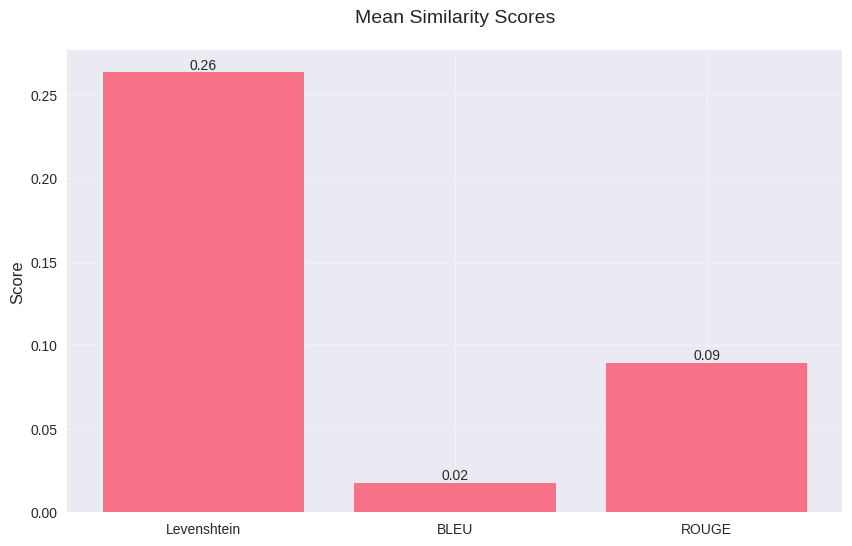

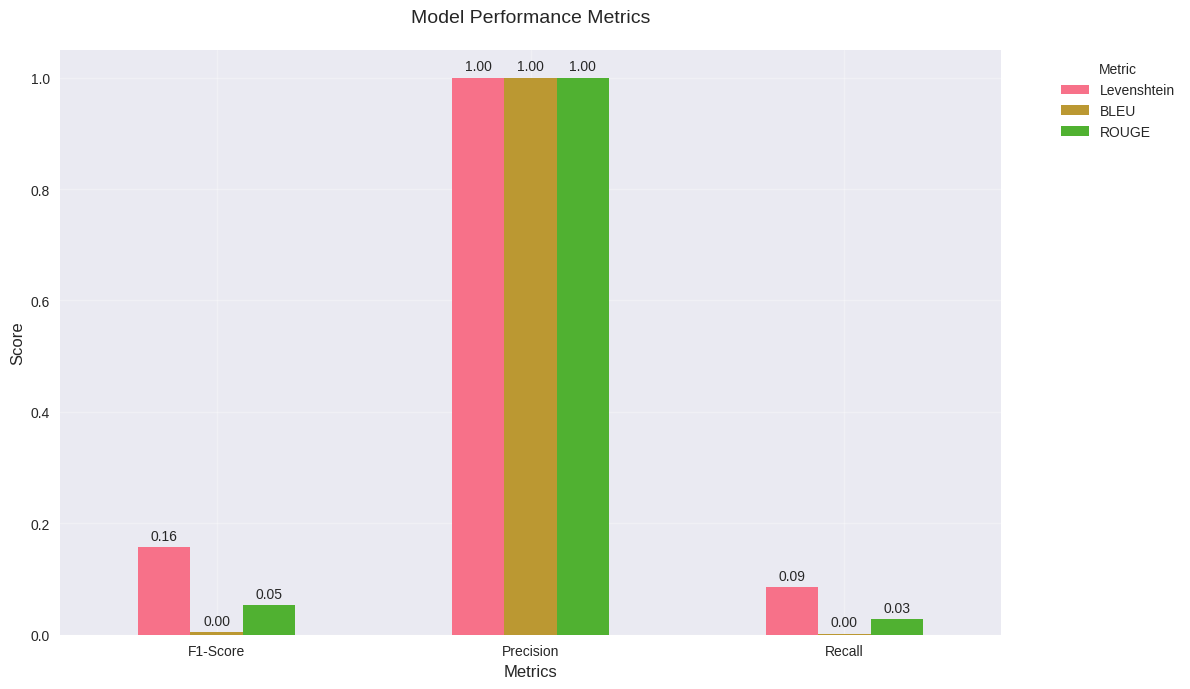

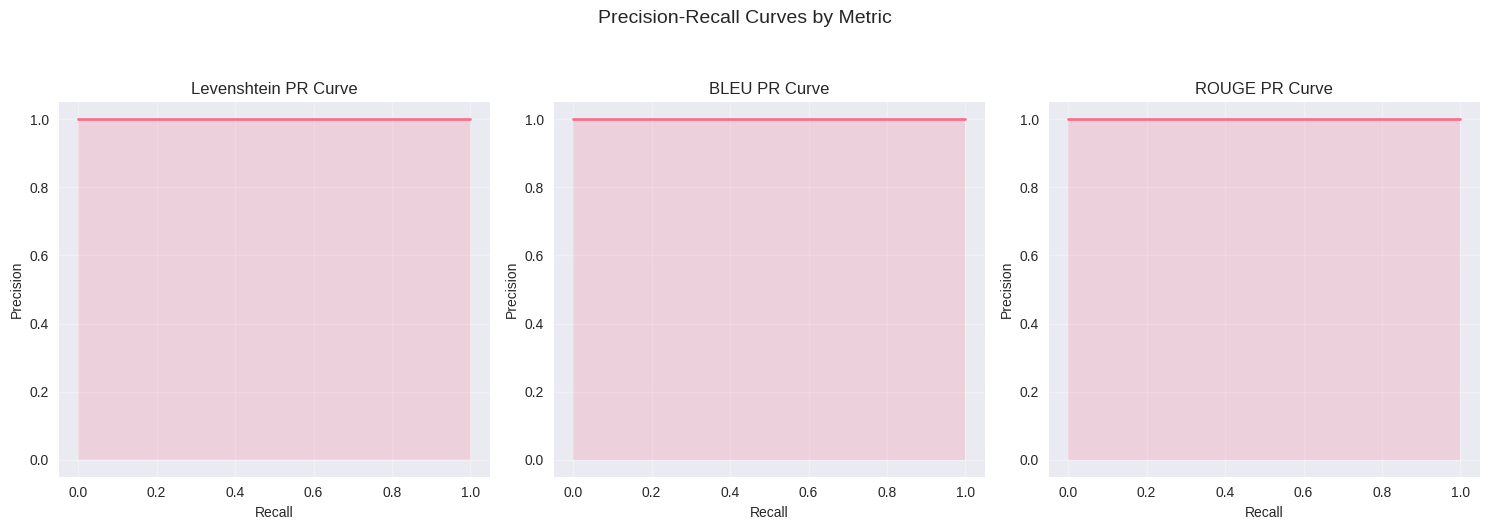

In [18]:
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_curve
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
!pip install rouge_score
from rouge_score import rouge_scorer
!pip install Levenshtein
from Levenshtein import ratio as levenshtein_ratio
import matplotlib.pyplot as plt
import nltk
import seaborn as sns


plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

try:
    nltk.data.find('tokenizers/punkt_tab')
except LookupError:
    nltk.download('punkt_tab')


rouge_scorer_instance = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
smoother = SmoothingFunction()


THRESHOLD = 0.4



df = df_results


levenshtein_scores, bleu_scores, rouge_scores = [], [], []
levenshtein_bool, bleu_bool, rouge_bool = [], [], []


for index, row in df.iterrows():
    ann = str(row["annotated_labels"])
    gen = str(row["parsed_topics"])


    lev_score = levenshtein_ratio(gen, ann)
    levenshtein_scores.append(lev_score)
    levenshtein_bool.append(lev_score > THRESHOLD)


    reference = nltk.word_tokenize(ann.lower())
    candidate = nltk.word_tokenize(gen.lower())
    bleu_score = sentence_bleu([reference], candidate, smoothing_function=smoother.method1)
    bleu_scores.append(bleu_score)
    bleu_bool.append(bleu_score > THRESHOLD)


    rouge_score = rouge_scorer_instance.score(ann, gen)['rougeL'].fmeasure
    rouge_scores.append(rouge_score)
    rouge_bool.append(rouge_score > THRESHOLD)


similarity_df = pd.DataFrame({
    "Levenshtein": levenshtein_scores,
    "BLEU": bleu_scores,
    "ROUGE": rouge_scores,
    "Levenshtein_Bool": levenshtein_bool,
    "BLEU_Bool": bleu_bool,
    "ROUGE_Bool": rouge_bool
})


mean_scores = {
    "Levenshtein": similarity_df["Levenshtein"].mean(),
    "BLEU": similarity_df["BLEU"].mean(),
    "ROUGE": similarity_df["ROUGE"].mean()
}


f1_scores = {
    "Levenshtein": f1_score([1] * len(levenshtein_bool), levenshtein_bool, zero_division=0),
    "BLEU": f1_score([1] * len(bleu_bool), bleu_bool, zero_division=0),
    "ROUGE": f1_score([1] * len(rouge_bool), rouge_bool, zero_division=0)
}

precision_scores = {
    "Levenshtein": precision_score([1] * len(levenshtein_bool), levenshtein_bool, zero_division=0),
    "BLEU": precision_score([1] * len(bleu_bool), bleu_bool, zero_division=0),
    "ROUGE": precision_score([1] * len(rouge_bool), rouge_bool, zero_division=0)
}

recall_scores = {
    "Levenshtein": recall_score([1] * len(levenshtein_bool), levenshtein_bool, zero_division=0),
    "BLEU": recall_score([1] * len(bleu_bool), bleu_bool, zero_division=0),
    "ROUGE": recall_score([1] * len(rouge_bool), rouge_bool, zero_division=0)
}


plt.figure(figsize=(10, 6))
bars = plt.bar(mean_scores.keys(), mean_scores.values())
plt.title("Mean Similarity Scores", fontsize=14, pad=20)
plt.ylabel("Score", fontsize=12)
plt.grid(True, alpha=0.3)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}',
             ha='center', va='bottom')
plt.show()


metrics_df = pd.DataFrame({
    "Levenshtein": [f1_scores["Levenshtein"], precision_scores["Levenshtein"], recall_scores["Levenshtein"]],
    "BLEU": [f1_scores["BLEU"], precision_scores["BLEU"], recall_scores["BLEU"]],
    "ROUGE": [f1_scores["ROUGE"], precision_scores["ROUGE"], recall_scores["ROUGE"]]
}, index=["F1-Score", "Precision", "Recall"])


ax = metrics_df.plot(kind="bar", figsize=(12, 7))
plt.title("Model Performance Metrics", fontsize=14, pad=20)
plt.ylabel("Score", fontsize=12)
plt.xlabel("Metrics", fontsize=12)
plt.xticks(rotation=0)
plt.legend(title="Metric", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)


for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', padding=3)
plt.tight_layout()
plt.show()


metrics = ["Levenshtein", "BLEU", "ROUGE"]
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Precision-Recall Curves by Metric', fontsize=14, y=1.05)

for idx, metric in enumerate(metrics):

    scores = similarity_df[metric]
    y_true = [1] * len(scores)


    precision, recall, _ = precision_recall_curve(y_true, scores)


    axes[idx].plot(recall, precision, linewidth=2)
    axes[idx].fill_between(recall, precision, alpha=0.2)
    axes[idx].set_xlabel('Recall', fontsize=10)
    axes[idx].set_ylabel('Precision', fontsize=10)
    axes[idx].set_title(f'{metric} PR Curve', fontsize=12)
    axes[idx].grid(True, alpha=0.3)
    axes[idx].set_xlim([-0.05, 1.05])
    axes[idx].set_ylim([-0.05, 1.05])

plt.tight_layout()
plt.show()